In [3]:
import os, importlib, sys, time

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import scipy.linalg as la
import scipy.stats as stats

In [6]:
import covidcast
from datetime import date

In [7]:
doi = [date(2020, 1, 22), date(2020, 8, 1)]

In [8]:
Y_raw = np.array(
    covidcast.signal("jhu-csse", "deaths_incidence_num",
                     doi[0], doi[1], "state", "pa")['value'])

In [9]:
A_raw = np.zeros([Y_raw.shape[0], 4])
A_raw[:,0] = np.array(
    covidcast.signal("safegraph", "completely_home_prop",
                     doi[0], doi[1], "state", "pa")['value'])
A_raw[:,1] = np.array(
    covidcast.signal("safegraph", "full_time_work_prop",
                     doi[0], doi[1], "state", "pa")['value'])
A_raw[:,2] = np.array(
    covidcast.signal("safegraph", "part_time_work_prop",
                     doi[0], doi[1], "state", "pa")['value'])
A_raw[:,3] = np.array(
    covidcast.signal("safegraph", "median_home_dwell_time",
                     doi[0], doi[1], "state", "pa")['value'])

In [10]:
Y_raw.shape

(193,)

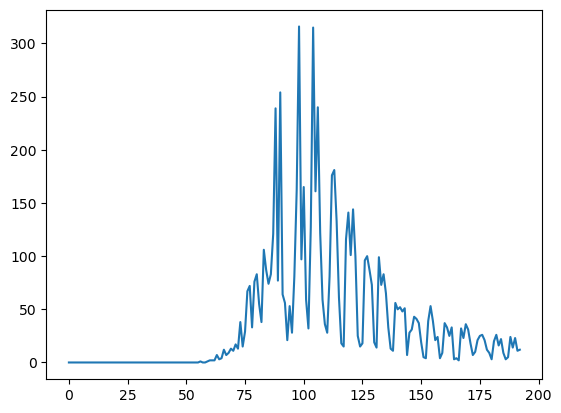

In [11]:
plt.plot(Y_raw)

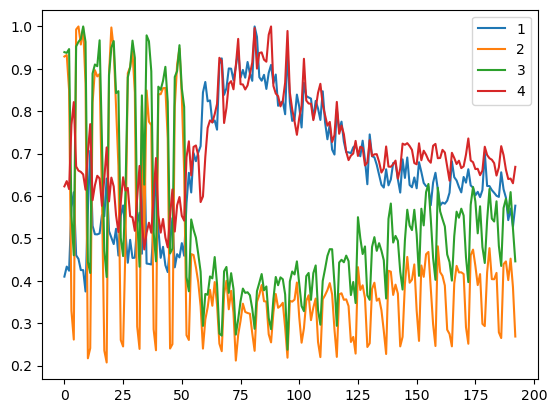

In [12]:
plt.plot(A_raw/np.max(A_raw, 0), label=[1,2,3,4])
plt.legend()

# 2. EDA

In [13]:
POI = np.sum(np.cumsum(Y_raw) < 10)
Y_data = Y_raw[POI:]

In [14]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

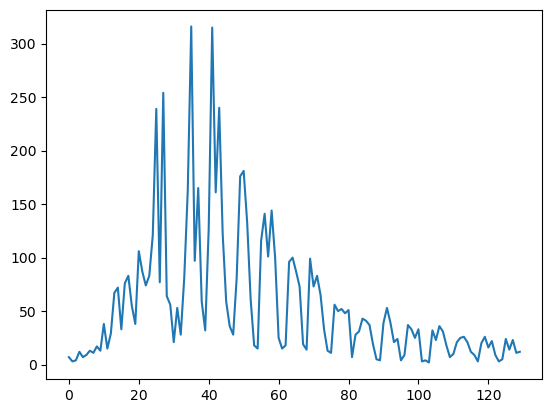

In [15]:
plt.plot(Y_data)

In [16]:
GPi = np.load('EuropeCovid2_GPi.npz')

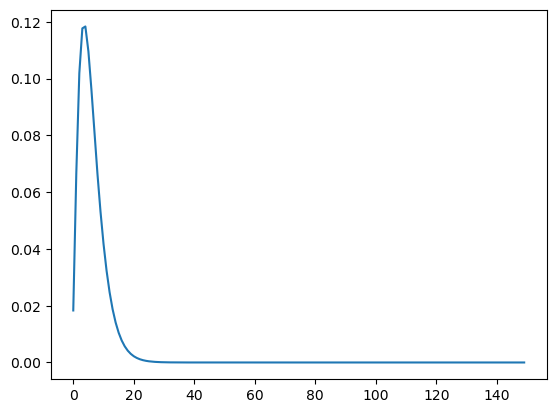

In [17]:
# g
g = np.zeros(T+T0)
g[:GPi['g'].shape[0]] = GPi['g']
plt.plot(g)

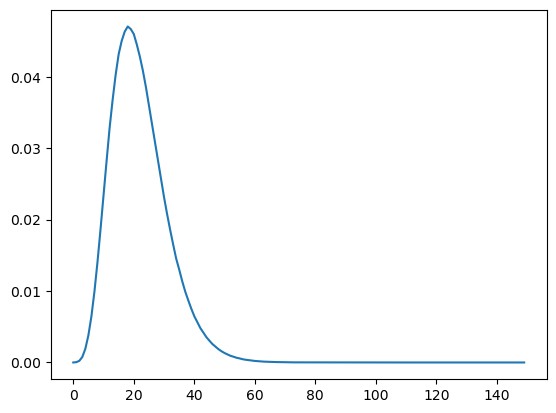

In [18]:
# pi
pi = np.zeros(T+T0)
pi[:GPi['pi'].shape[0]] = GPi['pi']
plt.plot(pi)

In [19]:
# A
d = 5
A = np.zeros([T+T0, d])

In [20]:
A[:,0] = np.full(T+T0, 1)
A[:,1:] = A_raw[POI-T0:,:]/np.max(A_raw, 0)

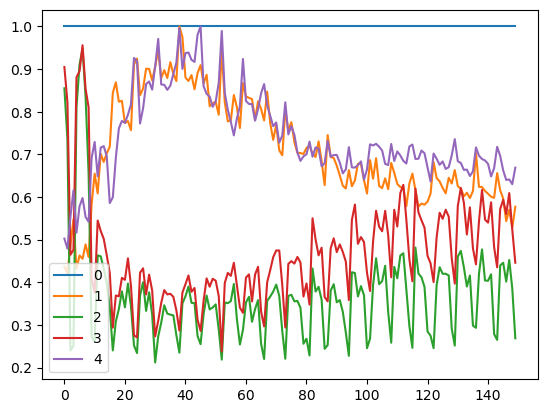

In [21]:
plt.plot(A, label=[0,1,2,3,4])
plt.legend()

# 3. fit by EM algorithm

In [22]:
def NBLL(y, m, r):
    y = int(y)
    return (np.sum(np.log(1+(r-1)/(np.arange(y)+1))) 
            + r * np.log(r/(r+m)) 
            + y * np.log(m/(r+m)))

In [23]:
def dNBLLdr(y, m, r):
    y = int(y)
    return (np.sum(1/(np.arange(y)+r)) + np.log(r/(r+m)) + (m-y)/(r+m))

In [24]:
def d2NBLLdr2(y, m, r):
    y = int(y)
    return (-np.sum(1/(np.arange(y)+r)**2) + 1/r + 1/(r+m) - (m-y)/(r+m)**2)

In [25]:
def fit(obs, rinit, minit_0, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    rhat = rinit
    mhat_0 = minit_0
    bhat= np.array(binit)
    ss = np.inf
        
    if history:
        rhs = np.zeros(n_iter)
        mhs_0 = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        lls = np.zeros(n_iter)
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(- bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
    if verbose:
        print("Before EM, ll: %f"%ll)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # derivatives
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        # first derivative
        dldEY = obs/EY - (rhat+obs)/(rhat+EY)
        
        dldr = np.sum([dNBLLdr(y, m, rhat) for y, m in zip(obs, EY)])
        dldm = np.sum(dldEY * Pi_inv_ImG[:,0])
        dldb = np.sum(dldEY * d1EY, 1)

        dldth = np.concatenate([[dldr, dldm], dldb])
        
        # second deivative
        d2ldEY2 = - obs/EY**2 + (rhat+obs)/(rhat+EY)**2
        d2ldrdEY = - 1/(rhat+EY) + (rhat+obs)/(rhat+EY)**2

        d2ldr2 = np.sum([d2NBLLdr2(y, m, rhat) for y, m in zip(obs, EY)])
        d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
        d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
               + np.sum(dldEY * d2EY, 2)

        d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
        d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
        d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
                + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)
        
        d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                            [d2ldrdm, d2ldm2]])
        d2ldrmdb = np.stack([d2ldrdb, 
                             d2ldmdb])
        
        d2ldth2 = np.block([[d2ldrm2, d2ldrmdb],
                            [d2ldrmdb.T, d2ldb2]])
        
        # Newton's method
        u, v = la.eig(-d2ldth2)
        # dth = np.real(((v/u) @ v.T) @ dldth)
        dth = np.real(((v/np.maximum(u,np.max(u)/1000)) @ v.T) @ dldth)
        ss = np.min([1, 1/np.sqrt(np.sum(dth**2))])
        
        rhat = np.abs(rhat + ss * dth[0])
        mhat_0 = mhat_0 + ss * dth[1]
        bhat = bhat + ss * dth[2:]
        
        for t in np.arange(T+T0):
            o = np.exp(- bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
        if history:
            rhs[i] = rhat
            mhs_0[i] = mhat_0
            bhs[i] = bhat
            lls[i] = ll
        
        if verbose:
            print("%d-th iteration finished, ll: %f, lapse: %.3fsec."
                  %(i+1, ll, time.time()-start_iter))
            
    if history:
        return rhs, mhs_0, bhs
    else:
        return rhat, mhat_0, bhat

In [26]:
rmle = 5.2
mmle_0 = 25.3
bmle = [0, 0, 0, 0, 0]

In [27]:
rhs, mhs_0, bhs =\
    fit(Y_data, rmle, mmle_0, bmle, 
        history=True, verbose=True, n_iter=10000, step_size=1)

Before EM, ll: -7906.486767
1-th iteration finished, ll: -2381.629145, lapse: 0.039sec.
2-th iteration finished, ll: -1810.703117, lapse: 0.026sec.
3-th iteration finished, ll: -1477.648034, lapse: 0.032sec.
4-th iteration finished, ll: -1236.388416, lapse: 0.027sec.
5-th iteration finished, ll: -1041.359325, lapse: 0.023sec.
6-th iteration finished, ll: -874.013736, lapse: 0.025sec.
7-th iteration finished, ll: -749.328764, lapse: 0.018sec.
8-th iteration finished, ll: -731.505239, lapse: 0.019sec.
9-th iteration finished, ll: -721.763858, lapse: 0.020sec.
10-th iteration finished, ll: -713.865066, lapse: 0.025sec.
11-th iteration finished, ll: -705.694756, lapse: 0.016sec.
12-th iteration finished, ll: -697.598492, lapse: 0.012sec.
13-th iteration finished, ll: -689.982298, lapse: 0.030sec.
14-th iteration finished, ll: -682.961686, lapse: 0.014sec.
15-th iteration finished, ll: -676.599613, lapse: 0.017sec.
16-th iteration finished, ll: -670.905299, lapse: 0.012sec.
17-th iteration 

149-th iteration finished, ll: -603.734434, lapse: 0.020sec.
150-th iteration finished, ll: -603.688936, lapse: 0.016sec.
151-th iteration finished, ll: -603.644185, lapse: 0.017sec.
152-th iteration finished, ll: -603.600167, lapse: 0.016sec.
153-th iteration finished, ll: -603.556867, lapse: 0.014sec.
154-th iteration finished, ll: -603.514270, lapse: 0.011sec.
155-th iteration finished, ll: -603.472363, lapse: 0.015sec.
156-th iteration finished, ll: -603.431130, lapse: 0.019sec.
157-th iteration finished, ll: -603.390560, lapse: 0.014sec.
158-th iteration finished, ll: -603.350640, lapse: 0.013sec.
159-th iteration finished, ll: -603.311355, lapse: 0.013sec.
160-th iteration finished, ll: -603.272694, lapse: 0.022sec.
161-th iteration finished, ll: -603.234645, lapse: 0.017sec.
162-th iteration finished, ll: -603.197195, lapse: 0.015sec.
163-th iteration finished, ll: -603.160334, lapse: 0.029sec.
164-th iteration finished, ll: -603.124049, lapse: 0.014sec.
165-th iteration finishe

284-th iteration finished, ll: -601.005021, lapse: 0.020sec.
285-th iteration finished, ll: -600.996743, lapse: 0.015sec.
286-th iteration finished, ll: -600.988535, lapse: 0.012sec.
287-th iteration finished, ll: -600.980397, lapse: 0.016sec.
288-th iteration finished, ll: -600.972328, lapse: 0.017sec.
289-th iteration finished, ll: -600.964326, lapse: 0.019sec.
290-th iteration finished, ll: -600.956390, lapse: 0.023sec.
291-th iteration finished, ll: -600.948520, lapse: 0.018sec.
292-th iteration finished, ll: -600.940715, lapse: 0.018sec.
293-th iteration finished, ll: -600.932973, lapse: 0.014sec.
294-th iteration finished, ll: -600.925293, lapse: 0.015sec.
295-th iteration finished, ll: -600.917675, lapse: 0.018sec.
296-th iteration finished, ll: -600.910118, lapse: 0.014sec.
297-th iteration finished, ll: -600.902621, lapse: 0.021sec.
298-th iteration finished, ll: -600.895182, lapse: 0.018sec.
299-th iteration finished, ll: -600.887801, lapse: 0.014sec.
300-th iteration finishe

429-th iteration finished, ll: -600.212765, lapse: 0.020sec.
430-th iteration finished, ll: -600.208782, lapse: 0.019sec.
431-th iteration finished, ll: -600.204809, lapse: 0.011sec.
432-th iteration finished, ll: -600.200845, lapse: 0.013sec.
433-th iteration finished, ll: -600.196891, lapse: 0.011sec.
434-th iteration finished, ll: -600.192946, lapse: 0.012sec.
435-th iteration finished, ll: -600.189011, lapse: 0.011sec.
436-th iteration finished, ll: -600.185085, lapse: 0.021sec.
437-th iteration finished, ll: -600.181167, lapse: 0.015sec.
438-th iteration finished, ll: -600.177259, lapse: 0.017sec.
439-th iteration finished, ll: -600.173360, lapse: 0.020sec.
440-th iteration finished, ll: -600.169469, lapse: 0.017sec.
441-th iteration finished, ll: -600.165587, lapse: 0.012sec.
442-th iteration finished, ll: -600.161713, lapse: 0.014sec.
443-th iteration finished, ll: -600.157848, lapse: 0.020sec.
444-th iteration finished, ll: -600.153992, lapse: 0.017sec.
445-th iteration finishe

575-th iteration finished, ll: -599.697371, lapse: 0.039sec.
576-th iteration finished, ll: -599.694138, lapse: 0.016sec.
577-th iteration finished, ll: -599.690908, lapse: 0.016sec.
578-th iteration finished, ll: -599.687680, lapse: 0.019sec.
579-th iteration finished, ll: -599.684455, lapse: 0.015sec.
580-th iteration finished, ll: -599.681232, lapse: 0.013sec.
581-th iteration finished, ll: -599.678012, lapse: 0.018sec.
582-th iteration finished, ll: -599.674795, lapse: 0.016sec.
583-th iteration finished, ll: -599.671580, lapse: 0.019sec.
584-th iteration finished, ll: -599.668368, lapse: 0.015sec.
585-th iteration finished, ll: -599.665159, lapse: 0.014sec.
586-th iteration finished, ll: -599.661952, lapse: 0.017sec.
587-th iteration finished, ll: -599.658747, lapse: 0.019sec.
588-th iteration finished, ll: -599.655545, lapse: 0.030sec.
589-th iteration finished, ll: -599.652345, lapse: 0.024sec.
590-th iteration finished, ll: -599.649148, lapse: 0.015sec.
591-th iteration finishe

713-th iteration finished, ll: -599.271259, lapse: 0.016sec.
714-th iteration finished, ll: -599.268290, lapse: 0.026sec.
715-th iteration finished, ll: -599.265322, lapse: 0.018sec.
716-th iteration finished, ll: -599.262356, lapse: 0.011sec.
717-th iteration finished, ll: -599.259391, lapse: 0.014sec.
718-th iteration finished, ll: -599.256427, lapse: 0.016sec.
719-th iteration finished, ll: -599.253465, lapse: 0.014sec.
720-th iteration finished, ll: -599.250504, lapse: 0.017sec.
721-th iteration finished, ll: -599.247545, lapse: 0.012sec.
722-th iteration finished, ll: -599.244587, lapse: 0.013sec.
723-th iteration finished, ll: -599.241630, lapse: 0.016sec.
724-th iteration finished, ll: -599.238675, lapse: 0.013sec.
725-th iteration finished, ll: -599.235720, lapse: 0.013sec.
726-th iteration finished, ll: -599.232768, lapse: 0.016sec.
727-th iteration finished, ll: -599.229816, lapse: 0.016sec.
728-th iteration finished, ll: -599.226866, lapse: 0.026sec.
729-th iteration finishe

853-th iteration finished, ll: -598.867169, lapse: 0.015sec.
854-th iteration finished, ll: -598.864354, lapse: 0.022sec.
855-th iteration finished, ll: -598.861540, lapse: 0.018sec.
856-th iteration finished, ll: -598.858727, lapse: 0.022sec.
857-th iteration finished, ll: -598.855915, lapse: 0.039sec.
858-th iteration finished, ll: -598.853104, lapse: 0.018sec.
859-th iteration finished, ll: -598.850294, lapse: 0.017sec.
860-th iteration finished, ll: -598.847484, lapse: 0.013sec.
861-th iteration finished, ll: -598.844675, lapse: 0.015sec.
862-th iteration finished, ll: -598.841868, lapse: 0.018sec.
863-th iteration finished, ll: -598.839061, lapse: 0.014sec.
864-th iteration finished, ll: -598.836255, lapse: 0.013sec.
865-th iteration finished, ll: -598.833449, lapse: 0.026sec.
866-th iteration finished, ll: -598.830645, lapse: 0.016sec.
867-th iteration finished, ll: -598.827841, lapse: 0.014sec.
868-th iteration finished, ll: -598.825038, lapse: 0.018sec.
869-th iteration finishe

994-th iteration finished, ll: -598.477692, lapse: 0.017sec.
995-th iteration finished, ll: -598.474975, lapse: 0.025sec.
996-th iteration finished, ll: -598.472259, lapse: 0.029sec.
997-th iteration finished, ll: -598.469543, lapse: 0.012sec.
998-th iteration finished, ll: -598.466828, lapse: 0.012sec.
999-th iteration finished, ll: -598.464114, lapse: 0.014sec.
1000-th iteration finished, ll: -598.461400, lapse: 0.015sec.
1001-th iteration finished, ll: -598.458687, lapse: 0.014sec.
1002-th iteration finished, ll: -598.455974, lapse: 0.018sec.
1003-th iteration finished, ll: -598.453262, lapse: 0.017sec.
1004-th iteration finished, ll: -598.450550, lapse: 0.016sec.
1005-th iteration finished, ll: -598.447839, lapse: 0.016sec.
1006-th iteration finished, ll: -598.445128, lapse: 0.027sec.
1007-th iteration finished, ll: -598.442418, lapse: 0.024sec.
1008-th iteration finished, ll: -598.439708, lapse: 0.014sec.
1009-th iteration finished, ll: -598.436999, lapse: 0.013sec.
1010-th iterat

1131-th iteration finished, ll: -598.109924, lapse: 0.023sec.
1132-th iteration finished, ll: -598.107267, lapse: 0.020sec.
1133-th iteration finished, ll: -598.104611, lapse: 0.015sec.
1134-th iteration finished, ll: -598.101955, lapse: 0.014sec.
1135-th iteration finished, ll: -598.099300, lapse: 0.017sec.
1136-th iteration finished, ll: -598.096645, lapse: 0.015sec.
1137-th iteration finished, ll: -598.093990, lapse: 0.013sec.
1138-th iteration finished, ll: -598.091336, lapse: 0.014sec.
1139-th iteration finished, ll: -598.088681, lapse: 0.017sec.
1140-th iteration finished, ll: -598.086028, lapse: 0.016sec.
1141-th iteration finished, ll: -598.083374, lapse: 0.015sec.
1142-th iteration finished, ll: -598.080721, lapse: 0.018sec.
1143-th iteration finished, ll: -598.078068, lapse: 0.013sec.
1144-th iteration finished, ll: -598.075416, lapse: 0.022sec.
1145-th iteration finished, ll: -598.072764, lapse: 0.031sec.
1146-th iteration finished, ll: -598.070112, lapse: 0.016sec.
1147-th 

1271-th iteration finished, ll: -597.740868, lapse: 0.023sec.
1272-th iteration finished, ll: -597.738250, lapse: 0.017sec.
1273-th iteration finished, ll: -597.735631, lapse: 0.013sec.
1274-th iteration finished, ll: -597.733013, lapse: 0.017sec.
1275-th iteration finished, ll: -597.730395, lapse: 0.013sec.
1276-th iteration finished, ll: -597.727777, lapse: 0.015sec.
1277-th iteration finished, ll: -597.725160, lapse: 0.019sec.
1278-th iteration finished, ll: -597.722542, lapse: 0.018sec.
1279-th iteration finished, ll: -597.719925, lapse: 0.014sec.
1280-th iteration finished, ll: -597.717308, lapse: 0.017sec.
1281-th iteration finished, ll: -597.714691, lapse: 0.014sec.
1282-th iteration finished, ll: -597.712075, lapse: 0.015sec.
1283-th iteration finished, ll: -597.709458, lapse: 0.015sec.
1284-th iteration finished, ll: -597.706842, lapse: 0.019sec.
1285-th iteration finished, ll: -597.704226, lapse: 0.022sec.
1286-th iteration finished, ll: -597.701610, lapse: 0.014sec.
1287-th 

1406-th iteration finished, ll: -597.388963, lapse: 0.023sec.
1407-th iteration finished, ll: -597.386366, lapse: 0.019sec.
1408-th iteration finished, ll: -597.383770, lapse: 0.015sec.
1409-th iteration finished, ll: -597.381174, lapse: 0.014sec.
1410-th iteration finished, ll: -597.378578, lapse: 0.016sec.
1411-th iteration finished, ll: -597.375982, lapse: 0.015sec.
1412-th iteration finished, ll: -597.373386, lapse: 0.016sec.
1413-th iteration finished, ll: -597.370791, lapse: 0.015sec.
1414-th iteration finished, ll: -597.368195, lapse: 0.014sec.
1415-th iteration finished, ll: -597.365600, lapse: 0.017sec.
1416-th iteration finished, ll: -597.363004, lapse: 0.017sec.
1417-th iteration finished, ll: -597.360409, lapse: 0.014sec.
1418-th iteration finished, ll: -597.357814, lapse: 0.014sec.
1419-th iteration finished, ll: -597.355219, lapse: 0.018sec.
1420-th iteration finished, ll: -597.352625, lapse: 0.025sec.
1421-th iteration finished, ll: -597.350030, lapse: 0.017sec.
1422-th 

1550-th iteration finished, ll: -597.016225, lapse: 0.021sec.
1551-th iteration finished, ll: -597.013644, lapse: 0.018sec.
1552-th iteration finished, ll: -597.011062, lapse: 0.016sec.
1553-th iteration finished, ll: -597.008481, lapse: 0.014sec.
1554-th iteration finished, ll: -597.005900, lapse: 0.016sec.
1555-th iteration finished, ll: -597.003319, lapse: 0.017sec.
1556-th iteration finished, ll: -597.000738, lapse: 0.018sec.
1557-th iteration finished, ll: -596.998157, lapse: 0.019sec.
1558-th iteration finished, ll: -596.995576, lapse: 0.029sec.
1559-th iteration finished, ll: -596.992995, lapse: 0.019sec.
1560-th iteration finished, ll: -596.990415, lapse: 0.021sec.
1561-th iteration finished, ll: -596.987834, lapse: 0.025sec.
1562-th iteration finished, ll: -596.985254, lapse: 0.030sec.
1563-th iteration finished, ll: -596.982673, lapse: 0.019sec.
1564-th iteration finished, ll: -596.980093, lapse: 0.026sec.
1565-th iteration finished, ll: -596.977513, lapse: 0.018sec.
1566-th 

1685-th iteration finished, ll: -596.668468, lapse: 0.023sec.
1686-th iteration finished, ll: -596.665898, lapse: 0.032sec.
1687-th iteration finished, ll: -596.663327, lapse: 0.039sec.
1688-th iteration finished, ll: -596.660757, lapse: 0.033sec.
1689-th iteration finished, ll: -596.658186, lapse: 0.031sec.
1690-th iteration finished, ll: -596.655616, lapse: 0.020sec.
1691-th iteration finished, ll: -596.653046, lapse: 0.032sec.
1692-th iteration finished, ll: -596.650476, lapse: 0.027sec.
1693-th iteration finished, ll: -596.647905, lapse: 0.025sec.
1694-th iteration finished, ll: -596.645335, lapse: 0.014sec.
1695-th iteration finished, ll: -596.642765, lapse: 0.027sec.
1696-th iteration finished, ll: -596.640196, lapse: 0.018sec.
1697-th iteration finished, ll: -596.637626, lapse: 0.019sec.
1698-th iteration finished, ll: -596.635056, lapse: 0.026sec.
1699-th iteration finished, ll: -596.632486, lapse: 0.025sec.
1700-th iteration finished, ll: -596.629917, lapse: 0.017sec.
1701-th 

1821-th iteration finished, ll: -596.319605, lapse: 0.044sec.
1822-th iteration finished, ll: -596.317046, lapse: 0.025sec.
1823-th iteration finished, ll: -596.314486, lapse: 0.019sec.
1824-th iteration finished, ll: -596.311927, lapse: 0.019sec.
1825-th iteration finished, ll: -596.309368, lapse: 0.022sec.
1826-th iteration finished, ll: -596.306809, lapse: 0.015sec.
1827-th iteration finished, ll: -596.304251, lapse: 0.020sec.
1828-th iteration finished, ll: -596.301692, lapse: 0.015sec.
1829-th iteration finished, ll: -596.299133, lapse: 0.018sec.
1830-th iteration finished, ll: -596.296575, lapse: 0.015sec.
1831-th iteration finished, ll: -596.294016, lapse: 0.014sec.
1832-th iteration finished, ll: -596.291458, lapse: 0.017sec.
1833-th iteration finished, ll: -596.288900, lapse: 0.026sec.
1834-th iteration finished, ll: -596.286342, lapse: 0.025sec.
1835-th iteration finished, ll: -596.283784, lapse: 0.020sec.
1836-th iteration finished, ll: -596.281226, lapse: 0.031sec.
1837-th 

1964-th iteration finished, ll: -595.954693, lapse: 0.029sec.
1965-th iteration finished, ll: -595.952150, lapse: 0.025sec.
1966-th iteration finished, ll: -595.949607, lapse: 0.034sec.
1967-th iteration finished, ll: -595.947063, lapse: 0.042sec.
1968-th iteration finished, ll: -595.944520, lapse: 0.016sec.
1969-th iteration finished, ll: -595.941978, lapse: 0.032sec.
1970-th iteration finished, ll: -595.939435, lapse: 0.017sec.
1971-th iteration finished, ll: -595.936892, lapse: 0.018sec.
1972-th iteration finished, ll: -595.934350, lapse: 0.045sec.
1973-th iteration finished, ll: -595.931808, lapse: 0.022sec.
1974-th iteration finished, ll: -595.929265, lapse: 0.040sec.
1975-th iteration finished, ll: -595.926723, lapse: 0.018sec.
1976-th iteration finished, ll: -595.924181, lapse: 0.018sec.
1977-th iteration finished, ll: -595.921640, lapse: 0.017sec.
1978-th iteration finished, ll: -595.919098, lapse: 0.039sec.
1979-th iteration finished, ll: -595.916556, lapse: 0.011sec.
1980-th 

2099-th iteration finished, ll: -595.612675, lapse: 0.025sec.
2100-th iteration finished, ll: -595.610152, lapse: 0.023sec.
2101-th iteration finished, ll: -595.607630, lapse: 0.017sec.
2102-th iteration finished, ll: -595.605109, lapse: 0.036sec.
2103-th iteration finished, ll: -595.602587, lapse: 0.022sec.
2104-th iteration finished, ll: -595.600065, lapse: 0.027sec.
2105-th iteration finished, ll: -595.597544, lapse: 0.015sec.
2106-th iteration finished, ll: -595.595023, lapse: 0.015sec.
2107-th iteration finished, ll: -595.592502, lapse: 0.013sec.
2108-th iteration finished, ll: -595.589981, lapse: 0.016sec.
2109-th iteration finished, ll: -595.587461, lapse: 0.013sec.
2110-th iteration finished, ll: -595.584940, lapse: 0.025sec.
2111-th iteration finished, ll: -595.582420, lapse: 0.019sec.
2112-th iteration finished, ll: -595.579900, lapse: 0.016sec.
2113-th iteration finished, ll: -595.577380, lapse: 0.021sec.
2114-th iteration finished, ll: -595.574861, lapse: 0.020sec.
2115-th 

2238-th iteration finished, ll: -595.264053, lapse: 0.029sec.
2239-th iteration finished, ll: -595.261561, lapse: 0.026sec.
2240-th iteration finished, ll: -595.259069, lapse: 0.013sec.
2241-th iteration finished, ll: -595.256578, lapse: 0.017sec.
2242-th iteration finished, ll: -595.254086, lapse: 0.014sec.
2243-th iteration finished, ll: -595.251595, lapse: 0.026sec.
2244-th iteration finished, ll: -595.249104, lapse: 0.015sec.
2245-th iteration finished, ll: -595.246614, lapse: 0.020sec.
2246-th iteration finished, ll: -595.244123, lapse: 0.017sec.
2247-th iteration finished, ll: -595.241633, lapse: 0.028sec.
2248-th iteration finished, ll: -595.239143, lapse: 0.021sec.
2249-th iteration finished, ll: -595.236654, lapse: 0.026sec.
2250-th iteration finished, ll: -595.234164, lapse: 0.027sec.
2251-th iteration finished, ll: -595.231675, lapse: 0.019sec.
2252-th iteration finished, ll: -595.229186, lapse: 0.014sec.
2253-th iteration finished, ll: -595.226698, lapse: 0.013sec.
2254-th 

2371-th iteration finished, ll: -594.935003, lapse: 0.039sec.
2372-th iteration finished, ll: -594.932549, lapse: 0.016sec.
2373-th iteration finished, ll: -594.930095, lapse: 0.022sec.
2374-th iteration finished, ll: -594.927642, lapse: 0.015sec.
2375-th iteration finished, ll: -594.925189, lapse: 0.013sec.
2376-th iteration finished, ll: -594.922736, lapse: 0.015sec.
2377-th iteration finished, ll: -594.920283, lapse: 0.021sec.
2378-th iteration finished, ll: -594.917831, lapse: 0.020sec.
2379-th iteration finished, ll: -594.915380, lapse: 0.024sec.
2380-th iteration finished, ll: -594.912928, lapse: 0.032sec.
2381-th iteration finished, ll: -594.910477, lapse: 0.029sec.
2382-th iteration finished, ll: -594.908026, lapse: 0.037sec.
2383-th iteration finished, ll: -594.905576, lapse: 0.027sec.
2384-th iteration finished, ll: -594.903125, lapse: 0.014sec.
2385-th iteration finished, ll: -594.900676, lapse: 0.022sec.
2386-th iteration finished, ll: -594.898226, lapse: 0.017sec.
2387-th 

2506-th iteration finished, ll: -594.606854, lapse: 0.027sec.
2507-th iteration finished, ll: -594.604448, lapse: 0.023sec.
2508-th iteration finished, ll: -594.602044, lapse: 0.018sec.
2509-th iteration finished, ll: -594.599639, lapse: 0.018sec.
2510-th iteration finished, ll: -594.597235, lapse: 0.018sec.
2511-th iteration finished, ll: -594.594831, lapse: 0.030sec.
2512-th iteration finished, ll: -594.592428, lapse: 0.020sec.
2513-th iteration finished, ll: -594.590025, lapse: 0.033sec.
2514-th iteration finished, ll: -594.587623, lapse: 0.021sec.
2515-th iteration finished, ll: -594.585221, lapse: 0.017sec.
2516-th iteration finished, ll: -594.582819, lapse: 0.014sec.
2517-th iteration finished, ll: -594.580418, lapse: 0.029sec.
2518-th iteration finished, ll: -594.578017, lapse: 0.017sec.
2519-th iteration finished, ll: -594.575617, lapse: 0.017sec.
2520-th iteration finished, ll: -594.573217, lapse: 0.018sec.
2521-th iteration finished, ll: -594.570817, lapse: 0.049sec.
2522-th 

2647-th iteration finished, ll: -594.271940, lapse: 0.022sec.
2648-th iteration finished, ll: -594.269597, lapse: 0.031sec.
2649-th iteration finished, ll: -594.267255, lapse: 0.023sec.
2650-th iteration finished, ll: -594.264913, lapse: 0.018sec.
2651-th iteration finished, ll: -594.262571, lapse: 0.017sec.
2652-th iteration finished, ll: -594.260230, lapse: 0.015sec.
2653-th iteration finished, ll: -594.257890, lapse: 0.015sec.
2654-th iteration finished, ll: -594.255550, lapse: 0.017sec.
2655-th iteration finished, ll: -594.253211, lapse: 0.016sec.
2656-th iteration finished, ll: -594.250871, lapse: 0.013sec.
2657-th iteration finished, ll: -594.248533, lapse: 0.023sec.
2658-th iteration finished, ll: -594.246195, lapse: 0.013sec.
2659-th iteration finished, ll: -594.243857, lapse: 0.034sec.
2660-th iteration finished, ll: -594.241520, lapse: 0.025sec.
2661-th iteration finished, ll: -594.239184, lapse: 0.024sec.
2662-th iteration finished, ll: -594.236848, lapse: 0.017sec.
2663-th 

2787-th iteration finished, ll: -593.948896, lapse: 0.016sec.
2788-th iteration finished, ll: -593.946626, lapse: 0.033sec.
2789-th iteration finished, ll: -593.944357, lapse: 0.022sec.
2790-th iteration finished, ll: -593.942089, lapse: 0.035sec.
2791-th iteration finished, ll: -593.939821, lapse: 0.019sec.
2792-th iteration finished, ll: -593.937553, lapse: 0.019sec.
2793-th iteration finished, ll: -593.935286, lapse: 0.024sec.
2794-th iteration finished, ll: -593.933020, lapse: 0.021sec.
2795-th iteration finished, ll: -593.930754, lapse: 0.013sec.
2796-th iteration finished, ll: -593.928489, lapse: 0.030sec.
2797-th iteration finished, ll: -593.926225, lapse: 0.024sec.
2798-th iteration finished, ll: -593.923961, lapse: 0.016sec.
2799-th iteration finished, ll: -593.921697, lapse: 0.033sec.
2800-th iteration finished, ll: -593.919434, lapse: 0.021sec.
2801-th iteration finished, ll: -593.917172, lapse: 0.021sec.
2802-th iteration finished, ll: -593.914910, lapse: 0.016sec.
2803-th 

2927-th iteration finished, ll: -593.636847, lapse: 0.030sec.
2928-th iteration finished, ll: -593.634661, lapse: 0.024sec.
2929-th iteration finished, ll: -593.632476, lapse: 0.015sec.
2930-th iteration finished, ll: -593.630291, lapse: 0.019sec.
2931-th iteration finished, ll: -593.628107, lapse: 0.017sec.
2932-th iteration finished, ll: -593.625923, lapse: 0.028sec.
2933-th iteration finished, ll: -593.623741, lapse: 0.019sec.
2934-th iteration finished, ll: -593.621559, lapse: 0.015sec.
2935-th iteration finished, ll: -593.619377, lapse: 0.019sec.
2936-th iteration finished, ll: -593.617196, lapse: 0.017sec.
2937-th iteration finished, ll: -593.615016, lapse: 0.017sec.
2938-th iteration finished, ll: -593.612836, lapse: 0.015sec.
2939-th iteration finished, ll: -593.610657, lapse: 0.025sec.
2940-th iteration finished, ll: -593.608479, lapse: 0.018sec.
2941-th iteration finished, ll: -593.606301, lapse: 0.013sec.
2942-th iteration finished, ll: -593.604124, lapse: 0.028sec.
2943-th 

3065-th iteration finished, ll: -593.341363, lapse: 0.015sec.
3066-th iteration finished, ll: -593.339269, lapse: 0.023sec.
3067-th iteration finished, ll: -593.337175, lapse: 0.019sec.
3068-th iteration finished, ll: -593.335082, lapse: 0.016sec.
3069-th iteration finished, ll: -593.332990, lapse: 0.016sec.
3070-th iteration finished, ll: -593.330898, lapse: 0.014sec.
3071-th iteration finished, ll: -593.328807, lapse: 0.013sec.
3072-th iteration finished, ll: -593.326717, lapse: 0.021sec.
3073-th iteration finished, ll: -593.324627, lapse: 0.020sec.
3074-th iteration finished, ll: -593.322539, lapse: 0.013sec.
3075-th iteration finished, ll: -593.320450, lapse: 0.014sec.
3076-th iteration finished, ll: -593.318363, lapse: 0.012sec.
3077-th iteration finished, ll: -593.316276, lapse: 0.016sec.
3078-th iteration finished, ll: -593.314190, lapse: 0.028sec.
3079-th iteration finished, ll: -593.312105, lapse: 0.021sec.
3080-th iteration finished, ll: -593.310020, lapse: 0.016sec.
3081-th 

3202-th iteration finished, ll: -593.061022, lapse: 0.013sec.
3203-th iteration finished, ll: -593.059026, lapse: 0.022sec.
3204-th iteration finished, ll: -593.057030, lapse: 0.015sec.
3205-th iteration finished, ll: -593.055036, lapse: 0.017sec.
3206-th iteration finished, ll: -593.053041, lapse: 0.019sec.
3207-th iteration finished, ll: -593.051048, lapse: 0.013sec.
3208-th iteration finished, ll: -593.049055, lapse: 0.016sec.
3209-th iteration finished, ll: -593.047063, lapse: 0.015sec.
3210-th iteration finished, ll: -593.045072, lapse: 0.018sec.
3211-th iteration finished, ll: -593.043081, lapse: 0.013sec.
3212-th iteration finished, ll: -593.041092, lapse: 0.014sec.
3213-th iteration finished, ll: -593.039103, lapse: 0.015sec.
3214-th iteration finished, ll: -593.037114, lapse: 0.019sec.
3215-th iteration finished, ll: -593.035127, lapse: 0.022sec.
3216-th iteration finished, ll: -593.033140, lapse: 0.018sec.
3217-th iteration finished, ll: -593.031154, lapse: 0.017sec.
3218-th 

3345-th iteration finished, ll: -592.783143, lapse: 0.025sec.
3346-th iteration finished, ll: -592.781255, lapse: 0.016sec.
3347-th iteration finished, ll: -592.779367, lapse: 0.017sec.
3348-th iteration finished, ll: -592.777480, lapse: 0.014sec.
3349-th iteration finished, ll: -592.775594, lapse: 0.014sec.
3350-th iteration finished, ll: -592.773708, lapse: 0.015sec.
3351-th iteration finished, ll: -592.771824, lapse: 0.010sec.
3352-th iteration finished, ll: -592.769940, lapse: 0.020sec.
3353-th iteration finished, ll: -592.768057, lapse: 0.018sec.
3354-th iteration finished, ll: -592.766174, lapse: 0.015sec.
3355-th iteration finished, ll: -592.764293, lapse: 0.017sec.
3356-th iteration finished, ll: -592.762412, lapse: 0.014sec.
3357-th iteration finished, ll: -592.760532, lapse: 0.017sec.
3358-th iteration finished, ll: -592.758653, lapse: 0.015sec.
3359-th iteration finished, ll: -592.756774, lapse: 0.027sec.
3360-th iteration finished, ll: -592.754896, lapse: 0.018sec.
3361-th 

3490-th iteration finished, ll: -592.517413, lapse: 0.028sec.
3491-th iteration finished, ll: -592.515638, lapse: 0.022sec.
3492-th iteration finished, ll: -592.513863, lapse: 0.021sec.
3493-th iteration finished, ll: -592.512089, lapse: 0.016sec.
3494-th iteration finished, ll: -592.510316, lapse: 0.013sec.
3495-th iteration finished, ll: -592.508543, lapse: 0.014sec.
3496-th iteration finished, ll: -592.506772, lapse: 0.015sec.
3497-th iteration finished, ll: -592.505001, lapse: 0.016sec.
3498-th iteration finished, ll: -592.503231, lapse: 0.047sec.
3499-th iteration finished, ll: -592.501461, lapse: 0.013sec.
3500-th iteration finished, ll: -592.499693, lapse: 0.014sec.
3501-th iteration finished, ll: -592.497925, lapse: 0.020sec.
3502-th iteration finished, ll: -592.496158, lapse: 0.024sec.
3503-th iteration finished, ll: -592.494392, lapse: 0.021sec.
3504-th iteration finished, ll: -592.492627, lapse: 0.020sec.
3505-th iteration finished, ll: -592.490862, lapse: 0.012sec.
3506-th 

3630-th iteration finished, ll: -592.276502, lapse: 0.017sec.
3631-th iteration finished, ll: -592.274837, lapse: 0.020sec.
3632-th iteration finished, ll: -592.273172, lapse: 0.015sec.
3633-th iteration finished, ll: -592.271509, lapse: 0.013sec.
3634-th iteration finished, ll: -592.269846, lapse: 0.012sec.
3635-th iteration finished, ll: -592.268184, lapse: 0.016sec.
3636-th iteration finished, ll: -592.266522, lapse: 0.014sec.
3637-th iteration finished, ll: -592.264862, lapse: 0.013sec.
3638-th iteration finished, ll: -592.263202, lapse: 0.014sec.
3639-th iteration finished, ll: -592.261543, lapse: 0.015sec.
3640-th iteration finished, ll: -592.259885, lapse: 0.017sec.
3641-th iteration finished, ll: -592.258228, lapse: 0.014sec.
3642-th iteration finished, ll: -592.256571, lapse: 0.013sec.
3643-th iteration finished, ll: -592.254916, lapse: 0.018sec.
3644-th iteration finished, ll: -592.253261, lapse: 0.017sec.
3645-th iteration finished, ll: -592.251606, lapse: 0.024sec.
3646-th 

3764-th iteration finished, ll: -592.060368, lapse: 0.016sec.
3765-th iteration finished, ll: -592.058807, lapse: 0.033sec.
3766-th iteration finished, ll: -592.057248, lapse: 0.013sec.
3767-th iteration finished, ll: -592.055690, lapse: 0.015sec.
3768-th iteration finished, ll: -592.054132, lapse: 0.019sec.
3769-th iteration finished, ll: -592.052575, lapse: 0.013sec.
3770-th iteration finished, ll: -592.051019, lapse: 0.015sec.
3771-th iteration finished, ll: -592.049463, lapse: 0.019sec.
3772-th iteration finished, ll: -592.047908, lapse: 0.016sec.
3773-th iteration finished, ll: -592.046355, lapse: 0.013sec.
3774-th iteration finished, ll: -592.044802, lapse: 0.017sec.
3775-th iteration finished, ll: -592.043249, lapse: 0.015sec.
3776-th iteration finished, ll: -592.041698, lapse: 0.020sec.
3777-th iteration finished, ll: -592.040147, lapse: 0.031sec.
3778-th iteration finished, ll: -592.038597, lapse: 0.024sec.
3779-th iteration finished, ll: -592.037048, lapse: 0.017sec.
3780-th 

3909-th iteration finished, ll: -591.842220, lapse: 0.016sec.
3910-th iteration finished, ll: -591.840771, lapse: 0.022sec.
3911-th iteration finished, ll: -591.839324, lapse: 0.020sec.
3912-th iteration finished, ll: -591.837877, lapse: 0.019sec.
3913-th iteration finished, ll: -591.836430, lapse: 0.016sec.
3914-th iteration finished, ll: -591.834985, lapse: 0.021sec.
3915-th iteration finished, ll: -591.833540, lapse: 0.016sec.
3916-th iteration finished, ll: -591.832096, lapse: 0.014sec.
3917-th iteration finished, ll: -591.830653, lapse: 0.012sec.
3918-th iteration finished, ll: -591.829210, lapse: 0.015sec.
3919-th iteration finished, ll: -591.827769, lapse: 0.015sec.
3920-th iteration finished, ll: -591.826328, lapse: 0.012sec.
3921-th iteration finished, ll: -591.824887, lapse: 0.015sec.
3922-th iteration finished, ll: -591.823448, lapse: 0.016sec.
3923-th iteration finished, ll: -591.822009, lapse: 0.035sec.
3924-th iteration finished, ll: -591.820571, lapse: 0.020sec.
3925-th 

4050-th iteration finished, ll: -591.645374, lapse: 0.018sec.
4051-th iteration finished, ll: -591.644031, lapse: 0.030sec.
4052-th iteration finished, ll: -591.642688, lapse: 0.014sec.
4053-th iteration finished, ll: -591.641346, lapse: 0.020sec.
4054-th iteration finished, ll: -591.640005, lapse: 0.016sec.
4055-th iteration finished, ll: -591.638664, lapse: 0.017sec.
4056-th iteration finished, ll: -591.637324, lapse: 0.014sec.
4057-th iteration finished, ll: -591.635985, lapse: 0.013sec.
4058-th iteration finished, ll: -591.634647, lapse: 0.016sec.
4059-th iteration finished, ll: -591.633309, lapse: 0.021sec.
4060-th iteration finished, ll: -591.631972, lapse: 0.015sec.
4061-th iteration finished, ll: -591.630636, lapse: 0.015sec.
4062-th iteration finished, ll: -591.629300, lapse: 0.014sec.
4063-th iteration finished, ll: -591.627966, lapse: 0.021sec.
4064-th iteration finished, ll: -591.626632, lapse: 0.027sec.
4065-th iteration finished, ll: -591.625298, lapse: 0.017sec.
4066-th 

4192-th iteration finished, ll: -591.461805, lapse: 0.013sec.
4193-th iteration finished, ll: -591.460563, lapse: 0.030sec.
4194-th iteration finished, ll: -591.459322, lapse: 0.014sec.
4195-th iteration finished, ll: -591.458081, lapse: 0.015sec.
4196-th iteration finished, ll: -591.456841, lapse: 0.015sec.
4197-th iteration finished, ll: -591.455602, lapse: 0.012sec.
4198-th iteration finished, ll: -591.454363, lapse: 0.016sec.
4199-th iteration finished, ll: -591.453125, lapse: 0.017sec.
4200-th iteration finished, ll: -591.451888, lapse: 0.015sec.
4201-th iteration finished, ll: -591.450652, lapse: 0.013sec.
4202-th iteration finished, ll: -591.449416, lapse: 0.015sec.
4203-th iteration finished, ll: -591.448181, lapse: 0.016sec.
4204-th iteration finished, ll: -591.446946, lapse: 0.013sec.
4205-th iteration finished, ll: -591.445713, lapse: 0.058sec.
4206-th iteration finished, ll: -591.444480, lapse: 0.022sec.
4207-th iteration finished, ll: -591.443247, lapse: 0.019sec.
4208-th 

4331-th iteration finished, ll: -591.295732, lapse: 0.031sec.
4332-th iteration finished, ll: -591.294584, lapse: 0.016sec.
4333-th iteration finished, ll: -591.293437, lapse: 0.014sec.
4334-th iteration finished, ll: -591.292291, lapse: 0.015sec.
4335-th iteration finished, ll: -591.291145, lapse: 0.012sec.
4336-th iteration finished, ll: -591.290000, lapse: 0.013sec.
4337-th iteration finished, ll: -591.288856, lapse: 0.015sec.
4338-th iteration finished, ll: -591.287712, lapse: 0.017sec.
4339-th iteration finished, ll: -591.286569, lapse: 0.015sec.
4340-th iteration finished, ll: -591.285427, lapse: 0.016sec.
4341-th iteration finished, ll: -591.284285, lapse: 0.016sec.
4342-th iteration finished, ll: -591.283144, lapse: 0.014sec.
4343-th iteration finished, ll: -591.282003, lapse: 0.013sec.
4344-th iteration finished, ll: -591.280864, lapse: 0.017sec.
4345-th iteration finished, ll: -591.279725, lapse: 0.022sec.
4346-th iteration finished, ll: -591.278586, lapse: 0.019sec.
4347-th 

4466-th iteration finished, ll: -591.146666, lapse: 0.035sec.
4467-th iteration finished, ll: -591.145605, lapse: 0.016sec.
4468-th iteration finished, ll: -591.144544, lapse: 0.012sec.
4469-th iteration finished, ll: -591.143485, lapse: 0.017sec.
4470-th iteration finished, ll: -591.142426, lapse: 0.014sec.
4471-th iteration finished, ll: -591.141367, lapse: 0.014sec.
4472-th iteration finished, ll: -591.140309, lapse: 0.010sec.
4473-th iteration finished, ll: -591.139252, lapse: 0.017sec.
4474-th iteration finished, ll: -591.138196, lapse: 0.014sec.
4475-th iteration finished, ll: -591.137140, lapse: 0.013sec.
4476-th iteration finished, ll: -591.136084, lapse: 0.016sec.
4477-th iteration finished, ll: -591.135030, lapse: 0.014sec.
4478-th iteration finished, ll: -591.133975, lapse: 0.013sec.
4479-th iteration finished, ll: -591.132922, lapse: 0.015sec.
4480-th iteration finished, ll: -591.131869, lapse: 0.014sec.
4481-th iteration finished, ll: -591.130817, lapse: 0.023sec.
4482-th 

4608-th iteration finished, ll: -591.002123, lapse: 0.023sec.
4609-th iteration finished, ll: -591.001148, lapse: 0.016sec.
4610-th iteration finished, ll: -591.000173, lapse: 0.021sec.
4611-th iteration finished, ll: -590.999199, lapse: 0.026sec.
4612-th iteration finished, ll: -590.998226, lapse: 0.041sec.
4613-th iteration finished, ll: -590.997253, lapse: 0.014sec.
4614-th iteration finished, ll: -590.996280, lapse: 0.033sec.
4615-th iteration finished, ll: -590.995309, lapse: 0.015sec.
4616-th iteration finished, ll: -590.994338, lapse: 0.013sec.
4617-th iteration finished, ll: -590.993367, lapse: 0.012sec.
4618-th iteration finished, ll: -590.992397, lapse: 0.011sec.
4619-th iteration finished, ll: -590.991428, lapse: 0.028sec.
4620-th iteration finished, ll: -590.990459, lapse: 0.020sec.
4621-th iteration finished, ll: -590.989491, lapse: 0.015sec.
4622-th iteration finished, ll: -590.988523, lapse: 0.017sec.
4623-th iteration finished, ll: -590.987556, lapse: 0.066sec.
4624-th 

4745-th iteration finished, ll: -590.873835, lapse: 0.014sec.
4746-th iteration finished, ll: -590.872937, lapse: 0.026sec.
4747-th iteration finished, ll: -590.872039, lapse: 0.016sec.
4748-th iteration finished, ll: -590.871142, lapse: 0.017sec.
4749-th iteration finished, ll: -590.870246, lapse: 0.018sec.
4750-th iteration finished, ll: -590.869350, lapse: 0.014sec.
4751-th iteration finished, ll: -590.868455, lapse: 0.017sec.
4752-th iteration finished, ll: -590.867561, lapse: 0.016sec.
4753-th iteration finished, ll: -590.866666, lapse: 0.014sec.
4754-th iteration finished, ll: -590.865773, lapse: 0.015sec.
4755-th iteration finished, ll: -590.864880, lapse: 0.016sec.
4756-th iteration finished, ll: -590.863987, lapse: 0.014sec.
4757-th iteration finished, ll: -590.863095, lapse: 0.017sec.
4758-th iteration finished, ll: -590.862204, lapse: 0.044sec.
4759-th iteration finished, ll: -590.861313, lapse: 0.023sec.
4760-th iteration finished, ll: -590.860423, lapse: 0.016sec.
4761-th 

4883-th iteration finished, ll: -590.754953, lapse: 0.025sec.
4884-th iteration finished, ll: -590.754128, lapse: 0.017sec.
4885-th iteration finished, ll: -590.753303, lapse: 0.016sec.
4886-th iteration finished, ll: -590.752479, lapse: 0.018sec.
4887-th iteration finished, ll: -590.751655, lapse: 0.014sec.
4888-th iteration finished, ll: -590.750832, lapse: 0.019sec.
4889-th iteration finished, ll: -590.750009, lapse: 0.014sec.
4890-th iteration finished, ll: -590.749187, lapse: 0.016sec.
4891-th iteration finished, ll: -590.748365, lapse: 0.012sec.
4892-th iteration finished, ll: -590.747544, lapse: 0.013sec.
4893-th iteration finished, ll: -590.746723, lapse: 0.016sec.
4894-th iteration finished, ll: -590.745902, lapse: 0.011sec.
4895-th iteration finished, ll: -590.745083, lapse: 0.013sec.
4896-th iteration finished, ll: -590.744263, lapse: 0.015sec.
4897-th iteration finished, ll: -590.743445, lapse: 0.024sec.
4898-th iteration finished, ll: -590.742626, lapse: 0.017sec.
4899-th 

5026-th iteration finished, ll: -590.641945, lapse: 0.020sec.
5027-th iteration finished, ll: -590.641190, lapse: 0.023sec.
5028-th iteration finished, ll: -590.640435, lapse: 0.023sec.
5029-th iteration finished, ll: -590.639680, lapse: 0.013sec.
5030-th iteration finished, ll: -590.638926, lapse: 0.017sec.
5031-th iteration finished, ll: -590.638172, lapse: 0.019sec.
5032-th iteration finished, ll: -590.637419, lapse: 0.011sec.
5033-th iteration finished, ll: -590.636666, lapse: 0.014sec.
5034-th iteration finished, ll: -590.635913, lapse: 0.012sec.
5035-th iteration finished, ll: -590.635162, lapse: 0.036sec.
5036-th iteration finished, ll: -590.634410, lapse: 0.014sec.
5037-th iteration finished, ll: -590.633659, lapse: 0.014sec.
5038-th iteration finished, ll: -590.632909, lapse: 0.030sec.
5039-th iteration finished, ll: -590.632159, lapse: 0.029sec.
5040-th iteration finished, ll: -590.631409, lapse: 0.016sec.
5041-th iteration finished, ll: -590.630660, lapse: 0.015sec.
5042-th 

5168-th iteration finished, ll: -590.539219, lapse: 0.025sec.
5169-th iteration finished, ll: -590.538527, lapse: 0.024sec.
5170-th iteration finished, ll: -590.537836, lapse: 0.021sec.
5171-th iteration finished, ll: -590.537145, lapse: 0.022sec.
5172-th iteration finished, ll: -590.536455, lapse: 0.020sec.
5173-th iteration finished, ll: -590.535765, lapse: 0.017sec.
5174-th iteration finished, ll: -590.535075, lapse: 0.016sec.
5175-th iteration finished, ll: -590.534386, lapse: 0.017sec.
5176-th iteration finished, ll: -590.533698, lapse: 0.022sec.
5177-th iteration finished, ll: -590.533009, lapse: 0.015sec.
5178-th iteration finished, ll: -590.532322, lapse: 0.013sec.
5179-th iteration finished, ll: -590.531634, lapse: 0.018sec.
5180-th iteration finished, ll: -590.530947, lapse: 0.027sec.
5181-th iteration finished, ll: -590.530261, lapse: 0.018sec.
5182-th iteration finished, ll: -590.529575, lapse: 0.014sec.
5183-th iteration finished, ll: -590.528889, lapse: 0.013sec.
5184-th 

5302-th iteration finished, ll: -590.450293, lapse: 0.020sec.
5303-th iteration finished, ll: -590.449657, lapse: 0.023sec.
5304-th iteration finished, ll: -590.449022, lapse: 0.032sec.
5305-th iteration finished, ll: -590.448387, lapse: 0.014sec.
5306-th iteration finished, ll: -590.447752, lapse: 0.013sec.
5307-th iteration finished, ll: -590.447118, lapse: 0.016sec.
5308-th iteration finished, ll: -590.446484, lapse: 0.015sec.
5309-th iteration finished, ll: -590.445850, lapse: 0.013sec.
5310-th iteration finished, ll: -590.445217, lapse: 0.019sec.
5311-th iteration finished, ll: -590.444585, lapse: 0.016sec.
5312-th iteration finished, ll: -590.443952, lapse: 0.013sec.
5313-th iteration finished, ll: -590.443320, lapse: 0.012sec.
5314-th iteration finished, ll: -590.442689, lapse: 0.017sec.
5315-th iteration finished, ll: -590.442058, lapse: 0.023sec.
5316-th iteration finished, ll: -590.441427, lapse: 0.015sec.
5317-th iteration finished, ll: -590.440797, lapse: 0.018sec.
5318-th 

5435-th iteration finished, ll: -590.369138, lapse: 0.023sec.
5436-th iteration finished, ll: -590.368553, lapse: 0.024sec.
5437-th iteration finished, ll: -590.367969, lapse: 0.019sec.
5438-th iteration finished, ll: -590.367385, lapse: 0.014sec.
5439-th iteration finished, ll: -590.366801, lapse: 0.016sec.
5440-th iteration finished, ll: -590.366218, lapse: 0.011sec.
5441-th iteration finished, ll: -590.365635, lapse: 0.016sec.
5442-th iteration finished, ll: -590.365052, lapse: 0.018sec.
5443-th iteration finished, ll: -590.364470, lapse: 0.015sec.
5444-th iteration finished, ll: -590.363888, lapse: 0.050sec.
5445-th iteration finished, ll: -590.363307, lapse: 0.024sec.
5446-th iteration finished, ll: -590.362726, lapse: 0.024sec.
5447-th iteration finished, ll: -590.362145, lapse: 0.020sec.
5448-th iteration finished, ll: -590.361565, lapse: 0.019sec.
5449-th iteration finished, ll: -590.360985, lapse: 0.019sec.
5450-th iteration finished, ll: -590.360405, lapse: 0.016sec.
5451-th 

5578-th iteration finished, ll: -590.289161, lapse: 0.025sec.
5579-th iteration finished, ll: -590.288626, lapse: 0.024sec.
5580-th iteration finished, ll: -590.288093, lapse: 0.017sec.
5581-th iteration finished, ll: -590.287559, lapse: 0.013sec.
5582-th iteration finished, ll: -590.287026, lapse: 0.017sec.
5583-th iteration finished, ll: -590.286493, lapse: 0.014sec.
5584-th iteration finished, ll: -590.285961, lapse: 0.016sec.
5585-th iteration finished, ll: -590.285429, lapse: 0.017sec.
5586-th iteration finished, ll: -590.284897, lapse: 0.012sec.
5587-th iteration finished, ll: -590.284365, lapse: 0.017sec.
5588-th iteration finished, ll: -590.283834, lapse: 0.013sec.
5589-th iteration finished, ll: -590.283303, lapse: 0.016sec.
5590-th iteration finished, ll: -590.282773, lapse: 0.012sec.
5591-th iteration finished, ll: -590.282243, lapse: 0.014sec.
5592-th iteration finished, ll: -590.281713, lapse: 0.024sec.
5593-th iteration finished, ll: -590.281183, lapse: 0.019sec.
5594-th 

5714-th iteration finished, ll: -590.219537, lapse: 0.025sec.
5715-th iteration finished, ll: -590.219047, lapse: 0.016sec.
5716-th iteration finished, ll: -590.218557, lapse: 0.030sec.
5717-th iteration finished, ll: -590.218067, lapse: 0.030sec.
5718-th iteration finished, ll: -590.217578, lapse: 0.015sec.
5719-th iteration finished, ll: -590.217090, lapse: 0.015sec.
5720-th iteration finished, ll: -590.216601, lapse: 0.062sec.
5721-th iteration finished, ll: -590.216113, lapse: 0.016sec.
5722-th iteration finished, ll: -590.215625, lapse: 0.013sec.
5723-th iteration finished, ll: -590.215138, lapse: 0.027sec.
5724-th iteration finished, ll: -590.214650, lapse: 0.023sec.
5725-th iteration finished, ll: -590.214164, lapse: 0.017sec.
5726-th iteration finished, ll: -590.213677, lapse: 0.012sec.
5727-th iteration finished, ll: -590.213191, lapse: 0.016sec.
5728-th iteration finished, ll: -590.212705, lapse: 0.013sec.
5729-th iteration finished, ll: -590.212219, lapse: 0.019sec.
5730-th 

5856-th iteration finished, ll: -590.152982, lapse: 0.028sec.
5857-th iteration finished, ll: -590.152535, lapse: 0.014sec.
5858-th iteration finished, ll: -590.152087, lapse: 0.019sec.
5859-th iteration finished, ll: -590.151640, lapse: 0.017sec.
5860-th iteration finished, ll: -590.151193, lapse: 0.015sec.
5861-th iteration finished, ll: -590.150747, lapse: 0.017sec.
5862-th iteration finished, ll: -590.150301, lapse: 0.013sec.
5863-th iteration finished, ll: -590.149855, lapse: 0.014sec.
5864-th iteration finished, ll: -590.149409, lapse: 0.017sec.
5865-th iteration finished, ll: -590.148963, lapse: 0.012sec.
5866-th iteration finished, ll: -590.148518, lapse: 0.015sec.
5867-th iteration finished, ll: -590.148073, lapse: 0.016sec.
5868-th iteration finished, ll: -590.147629, lapse: 0.018sec.
5869-th iteration finished, ll: -590.147184, lapse: 0.015sec.
5870-th iteration finished, ll: -590.146740, lapse: 0.057sec.
5871-th iteration finished, ll: -590.146297, lapse: 0.014sec.
5872-th 

5994-th iteration finished, ll: -590.093815, lapse: 0.029sec.
5995-th iteration finished, ll: -590.093405, lapse: 0.019sec.
5996-th iteration finished, ll: -590.092995, lapse: 0.014sec.
5997-th iteration finished, ll: -590.092585, lapse: 0.019sec.
5998-th iteration finished, ll: -590.092176, lapse: 0.016sec.
5999-th iteration finished, ll: -590.091767, lapse: 0.022sec.
6000-th iteration finished, ll: -590.091358, lapse: 0.017sec.
6001-th iteration finished, ll: -590.090950, lapse: 0.017sec.
6002-th iteration finished, ll: -590.090541, lapse: 0.013sec.
6003-th iteration finished, ll: -590.090133, lapse: 0.025sec.
6004-th iteration finished, ll: -590.089726, lapse: 0.014sec.
6005-th iteration finished, ll: -590.089318, lapse: 0.014sec.
6006-th iteration finished, ll: -590.088911, lapse: 0.027sec.
6007-th iteration finished, ll: -590.088504, lapse: 0.015sec.
6008-th iteration finished, ll: -590.088097, lapse: 0.018sec.
6009-th iteration finished, ll: -590.087691, lapse: 0.021sec.
6010-th 

6127-th iteration finished, ll: -590.041502, lapse: 0.034sec.
6128-th iteration finished, ll: -590.041126, lapse: 0.021sec.
6129-th iteration finished, ll: -590.040749, lapse: 0.012sec.
6130-th iteration finished, ll: -590.040373, lapse: 0.015sec.
6131-th iteration finished, ll: -590.039997, lapse: 0.018sec.
6132-th iteration finished, ll: -590.039621, lapse: 0.019sec.
6133-th iteration finished, ll: -590.039245, lapse: 0.013sec.
6134-th iteration finished, ll: -590.038870, lapse: 0.019sec.
6135-th iteration finished, ll: -590.038495, lapse: 0.017sec.
6136-th iteration finished, ll: -590.038120, lapse: 0.013sec.
6137-th iteration finished, ll: -590.037745, lapse: 0.014sec.
6138-th iteration finished, ll: -590.037371, lapse: 0.016sec.
6139-th iteration finished, ll: -590.036997, lapse: 0.014sec.
6140-th iteration finished, ll: -590.036623, lapse: 0.013sec.
6141-th iteration finished, ll: -590.036249, lapse: 0.022sec.
6142-th iteration finished, ll: -590.035876, lapse: 0.024sec.
6143-th 

6262-th iteration finished, ll: -589.992741, lapse: 0.031sec.
6263-th iteration finished, ll: -589.992396, lapse: 0.027sec.
6264-th iteration finished, ll: -589.992050, lapse: 0.021sec.
6265-th iteration finished, ll: -589.991705, lapse: 0.019sec.
6266-th iteration finished, ll: -589.991360, lapse: 0.015sec.
6267-th iteration finished, ll: -589.991015, lapse: 0.012sec.
6268-th iteration finished, ll: -589.990670, lapse: 0.016sec.
6269-th iteration finished, ll: -589.990325, lapse: 0.015sec.
6270-th iteration finished, ll: -589.989981, lapse: 0.012sec.
6271-th iteration finished, ll: -589.989637, lapse: 0.016sec.
6272-th iteration finished, ll: -589.989293, lapse: 0.017sec.
6273-th iteration finished, ll: -589.988950, lapse: 0.016sec.
6274-th iteration finished, ll: -589.988606, lapse: 0.013sec.
6275-th iteration finished, ll: -589.988263, lapse: 0.021sec.
6276-th iteration finished, ll: -589.987920, lapse: 0.031sec.
6277-th iteration finished, ll: -589.987577, lapse: 0.019sec.
6278-th 

6404-th iteration finished, ll: -589.945772, lapse: 0.022sec.
6405-th iteration finished, ll: -589.945456, lapse: 0.030sec.
6406-th iteration finished, ll: -589.945140, lapse: 0.013sec.
6407-th iteration finished, ll: -589.944824, lapse: 0.019sec.
6408-th iteration finished, ll: -589.944509, lapse: 0.016sec.
6409-th iteration finished, ll: -589.944194, lapse: 0.021sec.
6410-th iteration finished, ll: -589.943879, lapse: 0.016sec.
6411-th iteration finished, ll: -589.943564, lapse: 0.013sec.
6412-th iteration finished, ll: -589.943249, lapse: 0.015sec.
6413-th iteration finished, ll: -589.942935, lapse: 0.017sec.
6414-th iteration finished, ll: -589.942621, lapse: 0.015sec.
6415-th iteration finished, ll: -589.942307, lapse: 0.021sec.
6416-th iteration finished, ll: -589.941993, lapse: 0.014sec.
6417-th iteration finished, ll: -589.941679, lapse: 0.029sec.
6418-th iteration finished, ll: -589.941366, lapse: 0.017sec.
6419-th iteration finished, ll: -589.941053, lapse: 0.016sec.
6420-th 

6541-th iteration finished, ll: -589.904295, lapse: 0.026sec.
6542-th iteration finished, ll: -589.904005, lapse: 0.017sec.
6543-th iteration finished, ll: -589.903715, lapse: 0.027sec.
6544-th iteration finished, ll: -589.903426, lapse: 0.020sec.
6545-th iteration finished, ll: -589.903137, lapse: 0.020sec.
6546-th iteration finished, ll: -589.902848, lapse: 0.020sec.
6547-th iteration finished, ll: -589.902559, lapse: 0.017sec.
6548-th iteration finished, ll: -589.902271, lapse: 0.014sec.
6549-th iteration finished, ll: -589.901982, lapse: 0.017sec.
6550-th iteration finished, ll: -589.901694, lapse: 0.019sec.
6551-th iteration finished, ll: -589.901406, lapse: 0.018sec.
6552-th iteration finished, ll: -589.901118, lapse: 0.031sec.
6553-th iteration finished, ll: -589.900830, lapse: 0.026sec.
6554-th iteration finished, ll: -589.900543, lapse: 0.015sec.
6555-th iteration finished, ll: -589.900255, lapse: 0.016sec.
6556-th iteration finished, ll: -589.899968, lapse: 0.014sec.
6557-th 

6680-th iteration finished, ll: -589.865732, lapse: 0.015sec.
6681-th iteration finished, ll: -589.865467, lapse: 0.040sec.
6682-th iteration finished, ll: -589.865202, lapse: 0.028sec.
6683-th iteration finished, ll: -589.864937, lapse: 0.022sec.
6684-th iteration finished, ll: -589.864672, lapse: 0.034sec.
6685-th iteration finished, ll: -589.864407, lapse: 0.021sec.
6686-th iteration finished, ll: -589.864143, lapse: 0.016sec.
6687-th iteration finished, ll: -589.863879, lapse: 0.015sec.
6688-th iteration finished, ll: -589.863614, lapse: 0.026sec.
6689-th iteration finished, ll: -589.863350, lapse: 0.024sec.
6690-th iteration finished, ll: -589.863087, lapse: 0.038sec.
6691-th iteration finished, ll: -589.862823, lapse: 0.102sec.
6692-th iteration finished, ll: -589.862559, lapse: 0.016sec.
6693-th iteration finished, ll: -589.862296, lapse: 0.020sec.
6694-th iteration finished, ll: -589.862033, lapse: 0.017sec.
6695-th iteration finished, ll: -589.861770, lapse: 0.020sec.
6696-th 

6817-th iteration finished, ll: -589.830897, lapse: 0.027sec.
6818-th iteration finished, ll: -589.830654, lapse: 0.018sec.
6819-th iteration finished, ll: -589.830410, lapse: 0.018sec.
6820-th iteration finished, ll: -589.830167, lapse: 0.013sec.
6821-th iteration finished, ll: -589.829924, lapse: 0.017sec.
6822-th iteration finished, ll: -589.829682, lapse: 0.012sec.
6823-th iteration finished, ll: -589.829439, lapse: 0.013sec.
6824-th iteration finished, ll: -589.829197, lapse: 0.016sec.
6825-th iteration finished, ll: -589.828954, lapse: 0.012sec.
6826-th iteration finished, ll: -589.828712, lapse: 0.013sec.
6827-th iteration finished, ll: -589.828470, lapse: 0.015sec.
6828-th iteration finished, ll: -589.828228, lapse: 0.016sec.
6829-th iteration finished, ll: -589.827987, lapse: 0.016sec.
6830-th iteration finished, ll: -589.827745, lapse: 0.026sec.
6831-th iteration finished, ll: -589.827504, lapse: 0.022sec.
6832-th iteration finished, ll: -589.827262, lapse: 0.017sec.
6833-th 

6961-th iteration finished, ll: -589.797380, lapse: 0.023sec.
6962-th iteration finished, ll: -589.797158, lapse: 0.020sec.
6963-th iteration finished, ll: -589.796936, lapse: 0.020sec.
6964-th iteration finished, ll: -589.796714, lapse: 0.064sec.
6965-th iteration finished, ll: -589.796492, lapse: 0.020sec.
6966-th iteration finished, ll: -589.796270, lapse: 0.017sec.
6967-th iteration finished, ll: -589.796048, lapse: 0.012sec.
6968-th iteration finished, ll: -589.795827, lapse: 0.014sec.
6969-th iteration finished, ll: -589.795606, lapse: 0.016sec.
6970-th iteration finished, ll: -589.795384, lapse: 0.012sec.
6971-th iteration finished, ll: -589.795163, lapse: 0.014sec.
6972-th iteration finished, ll: -589.794942, lapse: 0.027sec.
6973-th iteration finished, ll: -589.794722, lapse: 0.023sec.
6974-th iteration finished, ll: -589.794501, lapse: 0.014sec.
6975-th iteration finished, ll: -589.794280, lapse: 0.014sec.
6976-th iteration finished, ll: -589.794060, lapse: 0.017sec.
6977-th 

7103-th iteration finished, ll: -589.767165, lapse: 0.027sec.
7104-th iteration finished, ll: -589.766962, lapse: 0.017sec.
7105-th iteration finished, ll: -589.766758, lapse: 0.020sec.
7106-th iteration finished, ll: -589.766555, lapse: 0.020sec.
7107-th iteration finished, ll: -589.766352, lapse: 0.014sec.
7108-th iteration finished, ll: -589.766149, lapse: 0.017sec.
7109-th iteration finished, ll: -589.765947, lapse: 0.018sec.
7110-th iteration finished, ll: -589.765744, lapse: 0.012sec.
7111-th iteration finished, ll: -589.765542, lapse: 0.018sec.
7112-th iteration finished, ll: -589.765339, lapse: 0.016sec.
7113-th iteration finished, ll: -589.765137, lapse: 0.016sec.
7114-th iteration finished, ll: -589.764935, lapse: 0.017sec.
7115-th iteration finished, ll: -589.764733, lapse: 0.066sec.
7116-th iteration finished, ll: -589.764531, lapse: 0.024sec.
7117-th iteration finished, ll: -589.764329, lapse: 0.016sec.
7118-th iteration finished, ll: -589.764127, lapse: 0.016sec.
7119-th 

7240-th iteration finished, ll: -589.740449, lapse: 0.077sec.
7241-th iteration finished, ll: -589.740262, lapse: 0.094sec.
7242-th iteration finished, ll: -589.740075, lapse: 0.015sec.
7243-th iteration finished, ll: -589.739889, lapse: 0.016sec.
7244-th iteration finished, ll: -589.739703, lapse: 0.023sec.
7245-th iteration finished, ll: -589.739516, lapse: 0.022sec.
7246-th iteration finished, ll: -589.739330, lapse: 0.016sec.
7247-th iteration finished, ll: -589.739144, lapse: 0.015sec.
7248-th iteration finished, ll: -589.738958, lapse: 0.014sec.
7249-th iteration finished, ll: -589.738772, lapse: 0.032sec.
7250-th iteration finished, ll: -589.738587, lapse: 0.017sec.
7251-th iteration finished, ll: -589.738401, lapse: 0.013sec.
7252-th iteration finished, ll: -589.738216, lapse: 0.015sec.
7253-th iteration finished, ll: -589.738030, lapse: 0.044sec.
7254-th iteration finished, ll: -589.737845, lapse: 0.024sec.
7255-th iteration finished, ll: -589.737660, lapse: 0.021sec.
7256-th 

7374-th iteration finished, ll: -589.716432, lapse: 0.020sec.
7375-th iteration finished, ll: -589.716260, lapse: 0.027sec.
7376-th iteration finished, ll: -589.716089, lapse: 0.016sec.
7377-th iteration finished, ll: -589.715917, lapse: 0.019sec.
7378-th iteration finished, ll: -589.715745, lapse: 0.015sec.
7379-th iteration finished, ll: -589.715574, lapse: 0.018sec.
7380-th iteration finished, ll: -589.715403, lapse: 0.018sec.
7381-th iteration finished, ll: -589.715232, lapse: 0.019sec.
7382-th iteration finished, ll: -589.715060, lapse: 0.018sec.
7383-th iteration finished, ll: -589.714889, lapse: 0.013sec.
7384-th iteration finished, ll: -589.714719, lapse: 0.014sec.
7385-th iteration finished, ll: -589.714548, lapse: 0.014sec.
7386-th iteration finished, ll: -589.714377, lapse: 0.017sec.
7387-th iteration finished, ll: -589.714207, lapse: 0.026sec.
7388-th iteration finished, ll: -589.714036, lapse: 0.022sec.
7389-th iteration finished, ll: -589.713866, lapse: 0.016sec.
7390-th 

7508-th iteration finished, ll: -589.694330, lapse: 0.022sec.
7509-th iteration finished, ll: -589.694172, lapse: 0.029sec.
7510-th iteration finished, ll: -589.694014, lapse: 0.022sec.
7511-th iteration finished, ll: -589.693856, lapse: 0.017sec.
7512-th iteration finished, ll: -589.693698, lapse: 0.015sec.
7513-th iteration finished, ll: -589.693541, lapse: 0.029sec.
7514-th iteration finished, ll: -589.693383, lapse: 0.021sec.
7515-th iteration finished, ll: -589.693225, lapse: 0.017sec.
7516-th iteration finished, ll: -589.693068, lapse: 0.018sec.
7517-th iteration finished, ll: -589.692910, lapse: 0.014sec.
7518-th iteration finished, ll: -589.692753, lapse: 0.014sec.
7519-th iteration finished, ll: -589.692596, lapse: 0.017sec.
7520-th iteration finished, ll: -589.692439, lapse: 0.030sec.
7521-th iteration finished, ll: -589.692282, lapse: 0.019sec.
7522-th iteration finished, ll: -589.692125, lapse: 0.014sec.
7523-th iteration finished, ll: -589.691968, lapse: 0.016sec.
7524-th 

7642-th iteration finished, ll: -589.673984, lapse: 0.080sec.
7643-th iteration finished, ll: -589.673838, lapse: 0.031sec.
7644-th iteration finished, ll: -589.673693, lapse: 0.028sec.
7645-th iteration finished, ll: -589.673547, lapse: 0.021sec.
7646-th iteration finished, ll: -589.673402, lapse: 0.019sec.
7647-th iteration finished, ll: -589.673257, lapse: 0.020sec.
7648-th iteration finished, ll: -589.673111, lapse: 0.021sec.
7649-th iteration finished, ll: -589.672966, lapse: 0.020sec.
7650-th iteration finished, ll: -589.672821, lapse: 0.020sec.
7651-th iteration finished, ll: -589.672676, lapse: 0.034sec.
7652-th iteration finished, ll: -589.672532, lapse: 0.027sec.
7653-th iteration finished, ll: -589.672387, lapse: 0.025sec.
7654-th iteration finished, ll: -589.672242, lapse: 0.018sec.
7655-th iteration finished, ll: -589.672098, lapse: 0.016sec.
7656-th iteration finished, ll: -589.671953, lapse: 0.017sec.
7657-th iteration finished, ll: -589.671809, lapse: 0.016sec.
7658-th 

7783-th iteration finished, ll: -589.654309, lapse: 0.028sec.
7784-th iteration finished, ll: -589.654176, lapse: 0.028sec.
7785-th iteration finished, ll: -589.654042, lapse: 0.033sec.
7786-th iteration finished, ll: -589.653909, lapse: 0.022sec.
7787-th iteration finished, ll: -589.653776, lapse: 0.029sec.
7788-th iteration finished, ll: -589.653642, lapse: 0.024sec.
7789-th iteration finished, ll: -589.653509, lapse: 0.021sec.
7790-th iteration finished, ll: -589.653376, lapse: 0.024sec.
7791-th iteration finished, ll: -589.653243, lapse: 0.018sec.
7792-th iteration finished, ll: -589.653110, lapse: 0.019sec.
7793-th iteration finished, ll: -589.652978, lapse: 0.022sec.
7794-th iteration finished, ll: -589.652845, lapse: 0.029sec.
7795-th iteration finished, ll: -589.652712, lapse: 0.022sec.
7796-th iteration finished, ll: -589.652580, lapse: 0.022sec.
7797-th iteration finished, ll: -589.652447, lapse: 0.017sec.
7798-th iteration finished, ll: -589.652315, lapse: 0.015sec.
7799-th 

7916-th iteration finished, ll: -589.637244, lapse: 0.028sec.
7917-th iteration finished, ll: -589.637121, lapse: 0.026sec.
7918-th iteration finished, ll: -589.636998, lapse: 0.026sec.
7919-th iteration finished, ll: -589.636875, lapse: 0.018sec.
7920-th iteration finished, ll: -589.636752, lapse: 0.018sec.
7921-th iteration finished, ll: -589.636630, lapse: 0.020sec.
7922-th iteration finished, ll: -589.636507, lapse: 0.021sec.
7923-th iteration finished, ll: -589.636384, lapse: 0.029sec.
7924-th iteration finished, ll: -589.636261, lapse: 0.021sec.
7925-th iteration finished, ll: -589.636139, lapse: 0.028sec.
7926-th iteration finished, ll: -589.636016, lapse: 0.033sec.
7927-th iteration finished, ll: -589.635894, lapse: 0.018sec.
7928-th iteration finished, ll: -589.635772, lapse: 0.016sec.
7929-th iteration finished, ll: -589.635650, lapse: 0.016sec.
7930-th iteration finished, ll: -589.635527, lapse: 0.014sec.
7931-th iteration finished, ll: -589.635405, lapse: 0.021sec.
7932-th 

8054-th iteration finished, ll: -589.620940, lapse: 0.023sec.
8055-th iteration finished, ll: -589.620827, lapse: 0.030sec.
8056-th iteration finished, ll: -589.620714, lapse: 0.028sec.
8057-th iteration finished, ll: -589.620601, lapse: 0.028sec.
8058-th iteration finished, ll: -589.620488, lapse: 0.032sec.
8059-th iteration finished, ll: -589.620375, lapse: 0.021sec.
8060-th iteration finished, ll: -589.620262, lapse: 0.018sec.
8061-th iteration finished, ll: -589.620149, lapse: 0.020sec.
8062-th iteration finished, ll: -589.620037, lapse: 0.031sec.
8063-th iteration finished, ll: -589.619924, lapse: 0.022sec.
8064-th iteration finished, ll: -589.619811, lapse: 0.018sec.
8065-th iteration finished, ll: -589.619699, lapse: 0.021sec.
8066-th iteration finished, ll: -589.619586, lapse: 0.022sec.
8067-th iteration finished, ll: -589.619474, lapse: 0.016sec.
8068-th iteration finished, ll: -589.619362, lapse: 0.017sec.
8069-th iteration finished, ll: -589.619249, lapse: 0.016sec.
8070-th 

8191-th iteration finished, ll: -589.606049, lapse: 0.013sec.
8192-th iteration finished, ll: -589.605945, lapse: 0.034sec.
8193-th iteration finished, ll: -589.605841, lapse: 0.018sec.
8194-th iteration finished, ll: -589.605737, lapse: 0.015sec.
8195-th iteration finished, ll: -589.605633, lapse: 0.015sec.
8196-th iteration finished, ll: -589.605529, lapse: 0.016sec.
8197-th iteration finished, ll: -589.605425, lapse: 0.015sec.
8198-th iteration finished, ll: -589.605321, lapse: 0.059sec.
8199-th iteration finished, ll: -589.605217, lapse: 0.013sec.
8200-th iteration finished, ll: -589.605114, lapse: 0.013sec.
8201-th iteration finished, ll: -589.605010, lapse: 0.061sec.
8202-th iteration finished, ll: -589.604906, lapse: 0.019sec.
8203-th iteration finished, ll: -589.604803, lapse: 0.024sec.
8204-th iteration finished, ll: -589.604699, lapse: 0.017sec.
8205-th iteration finished, ll: -589.604596, lapse: 0.018sec.
8206-th iteration finished, ll: -589.604493, lapse: 0.019sec.
8207-th 

8327-th iteration finished, ll: -589.592436, lapse: 0.026sec.
8328-th iteration finished, ll: -589.592340, lapse: 0.016sec.
8329-th iteration finished, ll: -589.592244, lapse: 0.021sec.
8330-th iteration finished, ll: -589.592148, lapse: 0.030sec.
8331-th iteration finished, ll: -589.592052, lapse: 0.026sec.
8332-th iteration finished, ll: -589.591956, lapse: 0.032sec.
8333-th iteration finished, ll: -589.591860, lapse: 0.021sec.
8334-th iteration finished, ll: -589.591765, lapse: 0.025sec.
8335-th iteration finished, ll: -589.591669, lapse: 0.022sec.
8336-th iteration finished, ll: -589.591574, lapse: 0.036sec.
8337-th iteration finished, ll: -589.591478, lapse: 0.020sec.
8338-th iteration finished, ll: -589.591383, lapse: 0.016sec.
8339-th iteration finished, ll: -589.591287, lapse: 0.012sec.
8340-th iteration finished, ll: -589.591192, lapse: 0.012sec.
8341-th iteration finished, ll: -589.591097, lapse: 0.012sec.
8342-th iteration finished, ll: -589.591001, lapse: 0.014sec.
8343-th 

8460-th iteration finished, ll: -589.580156, lapse: 0.026sec.
8461-th iteration finished, ll: -589.580067, lapse: 0.022sec.
8462-th iteration finished, ll: -589.579978, lapse: 0.023sec.
8463-th iteration finished, ll: -589.579890, lapse: 0.024sec.
8464-th iteration finished, ll: -589.579801, lapse: 0.042sec.
8465-th iteration finished, ll: -589.579713, lapse: 0.019sec.
8466-th iteration finished, ll: -589.579624, lapse: 0.015sec.
8467-th iteration finished, ll: -589.579536, lapse: 0.018sec.
8468-th iteration finished, ll: -589.579448, lapse: 0.017sec.
8469-th iteration finished, ll: -589.579359, lapse: 0.015sec.
8470-th iteration finished, ll: -589.579271, lapse: 0.018sec.
8471-th iteration finished, ll: -589.579183, lapse: 0.022sec.
8472-th iteration finished, ll: -589.579095, lapse: 0.018sec.
8473-th iteration finished, ll: -589.579007, lapse: 0.017sec.
8474-th iteration finished, ll: -589.578919, lapse: 0.012sec.
8475-th iteration finished, ll: -589.578831, lapse: 0.021sec.
8476-th 

8601-th iteration finished, ll: -589.568160, lapse: 0.023sec.
8602-th iteration finished, ll: -589.568078, lapse: 0.018sec.
8603-th iteration finished, ll: -589.567997, lapse: 0.034sec.
8604-th iteration finished, ll: -589.567915, lapse: 0.018sec.
8605-th iteration finished, ll: -589.567834, lapse: 0.020sec.
8606-th iteration finished, ll: -589.567752, lapse: 0.027sec.
8607-th iteration finished, ll: -589.567671, lapse: 0.021sec.
8608-th iteration finished, ll: -589.567590, lapse: 0.019sec.
8609-th iteration finished, ll: -589.567509, lapse: 0.017sec.
8610-th iteration finished, ll: -589.567428, lapse: 0.020sec.
8611-th iteration finished, ll: -589.567346, lapse: 0.029sec.
8612-th iteration finished, ll: -589.567265, lapse: 0.019sec.
8613-th iteration finished, ll: -589.567184, lapse: 0.025sec.
8614-th iteration finished, ll: -589.567103, lapse: 0.020sec.
8615-th iteration finished, ll: -589.567023, lapse: 0.020sec.
8616-th iteration finished, ll: -589.566942, lapse: 0.016sec.
8617-th 

8735-th iteration finished, ll: -589.557654, lapse: 0.031sec.
8736-th iteration finished, ll: -589.557579, lapse: 0.015sec.
8737-th iteration finished, ll: -589.557504, lapse: 0.017sec.
8738-th iteration finished, ll: -589.557429, lapse: 0.018sec.
8739-th iteration finished, ll: -589.557353, lapse: 0.018sec.
8740-th iteration finished, ll: -589.557278, lapse: 0.017sec.
8741-th iteration finished, ll: -589.557203, lapse: 0.015sec.
8742-th iteration finished, ll: -589.557128, lapse: 0.013sec.
8743-th iteration finished, ll: -589.557053, lapse: 0.016sec.
8744-th iteration finished, ll: -589.556978, lapse: 0.016sec.
8745-th iteration finished, ll: -589.556903, lapse: 0.018sec.
8746-th iteration finished, ll: -589.556829, lapse: 0.022sec.
8747-th iteration finished, ll: -589.556754, lapse: 0.015sec.
8748-th iteration finished, ll: -589.556679, lapse: 0.024sec.
8749-th iteration finished, ll: -589.556604, lapse: 0.031sec.
8750-th iteration finished, ll: -589.556530, lapse: 0.022sec.
8751-th 

8875-th iteration finished, ll: -589.547533, lapse: 0.022sec.
8876-th iteration finished, ll: -589.547464, lapse: 0.026sec.
8877-th iteration finished, ll: -589.547394, lapse: 0.014sec.
8878-th iteration finished, ll: -589.547325, lapse: 0.016sec.
8879-th iteration finished, ll: -589.547256, lapse: 0.014sec.
8880-th iteration finished, ll: -589.547187, lapse: 0.015sec.
8881-th iteration finished, ll: -589.547118, lapse: 0.016sec.
8882-th iteration finished, ll: -589.547049, lapse: 0.016sec.
8883-th iteration finished, ll: -589.546979, lapse: 0.016sec.
8884-th iteration finished, ll: -589.546910, lapse: 0.018sec.
8885-th iteration finished, ll: -589.546842, lapse: 0.013sec.
8886-th iteration finished, ll: -589.546773, lapse: 0.013sec.
8887-th iteration finished, ll: -589.546704, lapse: 0.014sec.
8888-th iteration finished, ll: -589.546635, lapse: 0.018sec.
8889-th iteration finished, ll: -589.546566, lapse: 0.036sec.
8890-th iteration finished, ll: -589.546497, lapse: 0.017sec.
8891-th 

9010-th iteration finished, ll: -589.538532, lapse: 0.021sec.
9011-th iteration finished, ll: -589.538468, lapse: 0.047sec.
9012-th iteration finished, ll: -589.538404, lapse: 0.020sec.
9013-th iteration finished, ll: -589.538340, lapse: 0.018sec.
9014-th iteration finished, ll: -589.538276, lapse: 0.015sec.
9015-th iteration finished, ll: -589.538212, lapse: 0.015sec.
9016-th iteration finished, ll: -589.538148, lapse: 0.016sec.
9017-th iteration finished, ll: -589.538085, lapse: 0.015sec.
9018-th iteration finished, ll: -589.538021, lapse: 0.013sec.
9019-th iteration finished, ll: -589.537957, lapse: 0.016sec.
9020-th iteration finished, ll: -589.537893, lapse: 0.017sec.
9021-th iteration finished, ll: -589.537830, lapse: 0.017sec.
9022-th iteration finished, ll: -589.537766, lapse: 0.026sec.
9023-th iteration finished, ll: -589.537702, lapse: 0.015sec.
9024-th iteration finished, ll: -589.537639, lapse: 0.020sec.
9025-th iteration finished, ll: -589.537575, lapse: 0.023sec.
9026-th 

9151-th iteration finished, ll: -589.529861, lapse: 0.028sec.
9152-th iteration finished, ll: -589.529802, lapse: 0.022sec.
9153-th iteration finished, ll: -589.529743, lapse: 0.022sec.
9154-th iteration finished, ll: -589.529684, lapse: 0.021sec.
9155-th iteration finished, ll: -589.529625, lapse: 0.023sec.
9156-th iteration finished, ll: -589.529566, lapse: 0.026sec.
9157-th iteration finished, ll: -589.529507, lapse: 0.022sec.
9158-th iteration finished, ll: -589.529449, lapse: 0.015sec.
9159-th iteration finished, ll: -589.529390, lapse: 0.012sec.
9160-th iteration finished, ll: -589.529331, lapse: 0.017sec.
9161-th iteration finished, ll: -589.529273, lapse: 0.022sec.
9162-th iteration finished, ll: -589.529214, lapse: 0.019sec.
9163-th iteration finished, ll: -589.529155, lapse: 0.022sec.
9164-th iteration finished, ll: -589.529097, lapse: 0.017sec.
9165-th iteration finished, ll: -589.529038, lapse: 0.022sec.
9166-th iteration finished, ll: -589.528980, lapse: 0.013sec.
9167-th 

9287-th iteration finished, ll: -589.522146, lapse: 0.014sec.
9288-th iteration finished, ll: -589.522091, lapse: 0.028sec.
9289-th iteration finished, ll: -589.522037, lapse: 0.023sec.
9290-th iteration finished, ll: -589.521982, lapse: 0.019sec.
9291-th iteration finished, ll: -589.521928, lapse: 0.020sec.
9292-th iteration finished, ll: -589.521873, lapse: 0.019sec.
9293-th iteration finished, ll: -589.521819, lapse: 0.025sec.
9294-th iteration finished, ll: -589.521765, lapse: 0.022sec.
9295-th iteration finished, ll: -589.521711, lapse: 0.022sec.
9296-th iteration finished, ll: -589.521656, lapse: 0.023sec.
9297-th iteration finished, ll: -589.521602, lapse: 0.024sec.
9298-th iteration finished, ll: -589.521548, lapse: 0.020sec.
9299-th iteration finished, ll: -589.521494, lapse: 0.027sec.
9300-th iteration finished, ll: -589.521440, lapse: 0.016sec.
9301-th iteration finished, ll: -589.521385, lapse: 0.015sec.
9302-th iteration finished, ll: -589.521331, lapse: 0.014sec.
9303-th 

9420-th iteration finished, ll: -589.515167, lapse: 0.022sec.
9421-th iteration finished, ll: -589.515116, lapse: 0.028sec.
9422-th iteration finished, ll: -589.515066, lapse: 0.025sec.
9423-th iteration finished, ll: -589.515015, lapse: 0.028sec.
9424-th iteration finished, ll: -589.514965, lapse: 0.017sec.
9425-th iteration finished, ll: -589.514915, lapse: 0.022sec.
9426-th iteration finished, ll: -589.514864, lapse: 0.014sec.
9427-th iteration finished, ll: -589.514814, lapse: 0.014sec.
9428-th iteration finished, ll: -589.514764, lapse: 0.015sec.
9429-th iteration finished, ll: -589.514714, lapse: 0.017sec.
9430-th iteration finished, ll: -589.514663, lapse: 0.016sec.
9431-th iteration finished, ll: -589.514613, lapse: 0.031sec.
9432-th iteration finished, ll: -589.514563, lapse: 0.015sec.
9433-th iteration finished, ll: -589.514513, lapse: 0.015sec.
9434-th iteration finished, ll: -589.514463, lapse: 0.013sec.
9435-th iteration finished, ll: -589.514413, lapse: 0.019sec.
9436-th 

9554-th iteration finished, ll: -589.508657, lapse: 0.024sec.
9555-th iteration finished, ll: -589.508610, lapse: 0.015sec.
9556-th iteration finished, ll: -589.508563, lapse: 0.018sec.
9557-th iteration finished, ll: -589.508517, lapse: 0.016sec.
9558-th iteration finished, ll: -589.508470, lapse: 0.017sec.
9559-th iteration finished, ll: -589.508423, lapse: 0.013sec.
9560-th iteration finished, ll: -589.508377, lapse: 0.014sec.
9561-th iteration finished, ll: -589.508330, lapse: 0.017sec.
9562-th iteration finished, ll: -589.508284, lapse: 0.017sec.
9563-th iteration finished, ll: -589.508237, lapse: 0.013sec.
9564-th iteration finished, ll: -589.508191, lapse: 0.017sec.
9565-th iteration finished, ll: -589.508144, lapse: 0.015sec.
9566-th iteration finished, ll: -589.508098, lapse: 0.016sec.
9567-th iteration finished, ll: -589.508051, lapse: 0.019sec.
9568-th iteration finished, ll: -589.508005, lapse: 0.023sec.
9569-th iteration finished, ll: -589.507959, lapse: 0.023sec.
9570-th 

9688-th iteration finished, ll: -589.502629, lapse: 0.039sec.
9689-th iteration finished, ll: -589.502585, lapse: 0.014sec.
9690-th iteration finished, ll: -589.502542, lapse: 0.018sec.
9691-th iteration finished, ll: -589.502499, lapse: 0.014sec.
9692-th iteration finished, ll: -589.502456, lapse: 0.014sec.
9693-th iteration finished, ll: -589.502412, lapse: 0.014sec.
9694-th iteration finished, ll: -589.502369, lapse: 0.017sec.
9695-th iteration finished, ll: -589.502326, lapse: 0.014sec.
9696-th iteration finished, ll: -589.502283, lapse: 0.017sec.
9697-th iteration finished, ll: -589.502240, lapse: 0.017sec.
9698-th iteration finished, ll: -589.502197, lapse: 0.014sec.
9699-th iteration finished, ll: -589.502154, lapse: 0.014sec.
9700-th iteration finished, ll: -589.502111, lapse: 0.013sec.
9701-th iteration finished, ll: -589.502068, lapse: 0.012sec.
9702-th iteration finished, ll: -589.502025, lapse: 0.031sec.
9703-th iteration finished, ll: -589.501982, lapse: 0.015sec.
9704-th 

9823-th iteration finished, ll: -589.497005, lapse: 0.019sec.
9824-th iteration finished, ll: -589.496965, lapse: 0.026sec.
9825-th iteration finished, ll: -589.496925, lapse: 0.015sec.
9826-th iteration finished, ll: -589.496885, lapse: 0.016sec.
9827-th iteration finished, ll: -589.496845, lapse: 0.018sec.
9828-th iteration finished, ll: -589.496805, lapse: 0.018sec.
9829-th iteration finished, ll: -589.496765, lapse: 0.014sec.
9830-th iteration finished, ll: -589.496725, lapse: 0.015sec.
9831-th iteration finished, ll: -589.496685, lapse: 0.017sec.
9832-th iteration finished, ll: -589.496645, lapse: 0.016sec.
9833-th iteration finished, ll: -589.496605, lapse: 0.017sec.
9834-th iteration finished, ll: -589.496565, lapse: 0.012sec.
9835-th iteration finished, ll: -589.496525, lapse: 0.016sec.
9836-th iteration finished, ll: -589.496486, lapse: 0.023sec.
9837-th iteration finished, ll: -589.496446, lapse: 0.020sec.
9838-th iteration finished, ll: -589.496406, lapse: 0.018sec.
9839-th 

9969-th iteration finished, ll: -589.491389, lapse: 0.021sec.
9970-th iteration finished, ll: -589.491352, lapse: 0.021sec.
9971-th iteration finished, ll: -589.491315, lapse: 0.024sec.
9972-th iteration finished, ll: -589.491279, lapse: 0.017sec.
9973-th iteration finished, ll: -589.491242, lapse: 0.016sec.
9974-th iteration finished, ll: -589.491205, lapse: 0.016sec.
9975-th iteration finished, ll: -589.491168, lapse: 0.017sec.
9976-th iteration finished, ll: -589.491131, lapse: 0.017sec.
9977-th iteration finished, ll: -589.491095, lapse: 0.022sec.
9978-th iteration finished, ll: -589.491058, lapse: 0.020sec.
9979-th iteration finished, ll: -589.491021, lapse: 0.014sec.
9980-th iteration finished, ll: -589.490985, lapse: 0.014sec.
9981-th iteration finished, ll: -589.490948, lapse: 0.031sec.
9982-th iteration finished, ll: -589.490911, lapse: 0.017sec.
9983-th iteration finished, ll: -589.490875, lapse: 0.019sec.
9984-th iteration finished, ll: -589.490838, lapse: 0.018sec.
9985-th 

In [28]:
rmle = rhs[-1]
mmle_0 = mhs_0[-1]
bmle = bhs[-1]

In [29]:
rmle, mmle_0, bmle

(2.583599645510284,
 8.639444833754256,
 array([-26.99437341,  41.32263992,  45.56077145,   3.99036986,
        -32.47670699]))

## plots

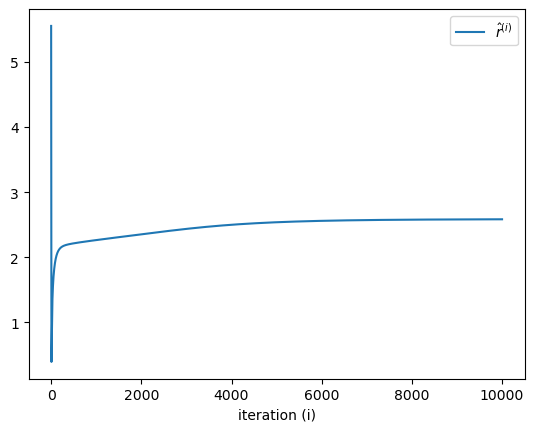

In [30]:
plt.plot(rhs, label=r"$\hat{r}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

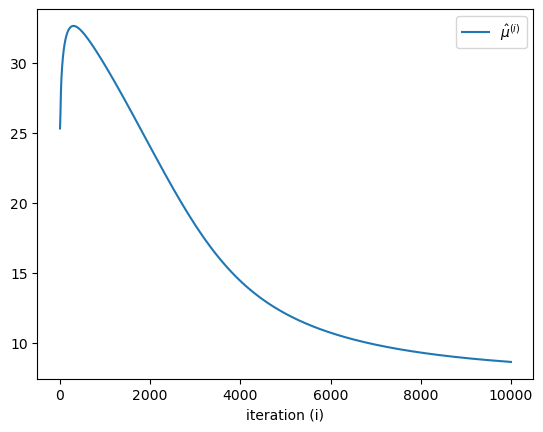

In [31]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

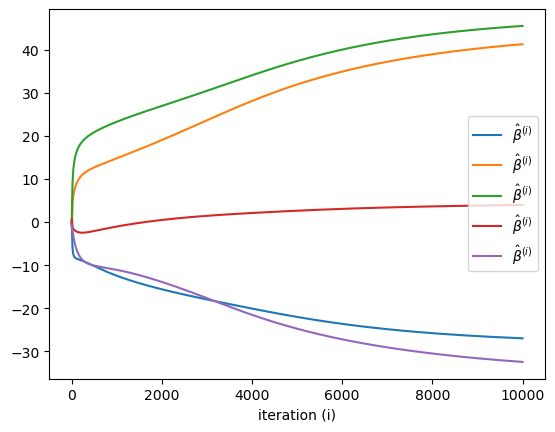

In [32]:
plt.plot(bhs, label=r"$\hat{\beta}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. Wald's Confidence Region

In [33]:
Rmle = np.zeros(T+T0)
d1Rm = np.zeros([d, T+T0])
d2Rm = np.zeros([d, d, T+T0])

In [73]:
Atilde = sp.signal.convolve2d(A, np.full(7,1/7)[:,None], 'same')

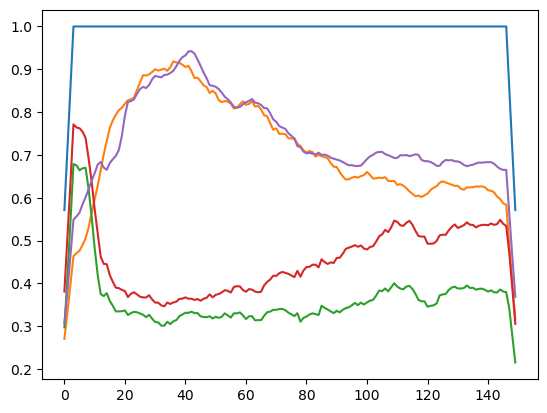

In [74]:
plt.plot(Atilde)

In [75]:
for t in np.arange(T+T0):
    o = np.exp(- bmle @ Atilde[t])
    p = 1 / (1 + o)
    q = o / (1 + o)

    Rmle[t] = K * p
    d1Rm[:,t] = K * p * q * Atilde[t]
    d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * Atilde[t])

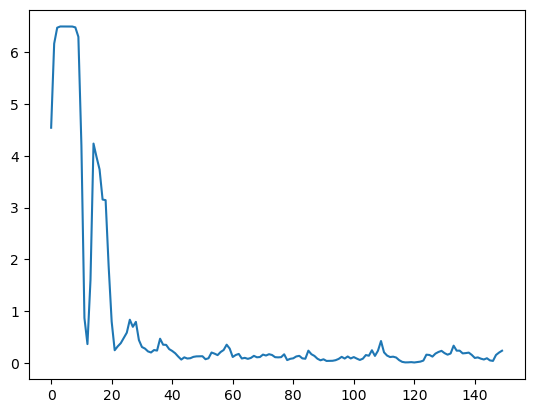

In [76]:
plt.plot(Rmle)

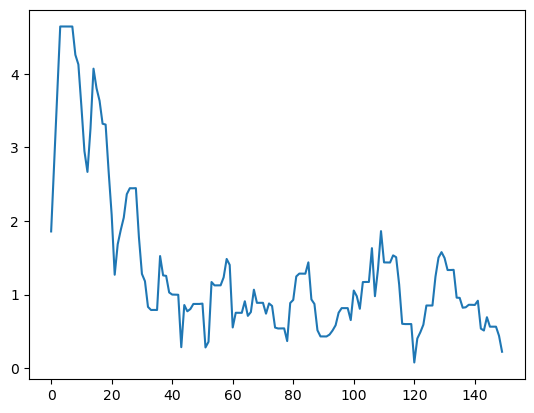

In [67]:
import scipy as sp
plt.plot(sp.signal.convolve(Rmle, np.full(7,1/7), 'same'))

In [36]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
G = Rmle[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [37]:
d1G = d1Rm[:,:,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
d2G = d2Rm[...,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [38]:
inv_ImG = la.inv(np.eye(T+T0)-G)

In [39]:
Pi_inv_ImG = Pi @ inv_ImG

In [40]:
EY = mmle_0 * Pi_inv_ImG[:,0]

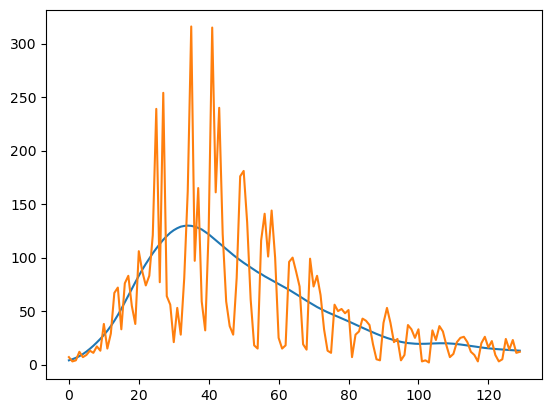

In [41]:
plt.plot(EY)
plt.plot(Y_data)

In [42]:
d1EY = mmle_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]

In [43]:
d2EY = mmle_0 * (Pi_inv_ImG @ (
    d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
    + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
    + d2G @ inv_ImG[:,:1]))[...,0]

In [44]:
dldEY = Y_data/EY - (rmle+Y_data)/(rmle+EY)
d2ldEY2 = - Y_data/EY**2 + (rmle+Y_data)/(rmle+EY)**2
d2ldrdEY = - 1/(rmle+EY) + (rmle+Y_data)/(rmle+EY)**2

In [45]:
d2ldr2 = np.sum([d2NBLLdr2(y, m, rmle) for y, m in zip(Y_data, EY)])
d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
       + np.sum(dldEY * d2EY, 2)

d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
        + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)

In [46]:
d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                    [d2ldrdm, d2ldm2]])
d2ldrmdb = np.stack([d2ldrdb, 
                     d2ldmdb])

In [47]:
Ihat_dth = - np.block([[d2ldrm2, d2ldrmdb],
                       [d2ldrmdb.T, d2ldb2]])

In [48]:
Ihat_dth

array([[ 1.04856699e+00, -3.32835895e-03,  2.19789468e-02,
         6.70993040e-03,  3.30698996e-03,  1.07526101e-02,
         2.01214788e-02],
       [-3.32835895e-03,  4.14388242e+00,  1.41197729e+02,
         1.11856577e+02,  5.23627215e+01,  6.17754785e+01,
         1.09745779e+02],
       [ 2.19789468e-02,  1.41197729e+02,  6.72308993e+03,
         5.26711352e+03,  2.51036019e+03,  2.99115415e+03,
         5.19822952e+03],
       [ 6.70993040e-03,  1.11856577e+02,  5.26711352e+03,
         4.13150538e+03,  1.96509220e+03,  2.33957773e+03,
         4.07587769e+03],
       [ 3.30698996e-03,  5.23627215e+01,  2.51036019e+03,
         1.96509220e+03,  9.37888740e+02,  1.11810991e+03,
         1.93990367e+03],
       [ 1.07526101e-02,  6.17754785e+01,  2.99115415e+03,
         2.33957773e+03,  1.11810991e+03,  1.33368783e+03,
         2.31023149e+03],
       [ 2.01214788e-02,  1.09745779e+02,  5.19822952e+03,
         4.07587769e+03,  1.93990367e+03,  2.31023149e+03,
         4.0216011

In [49]:
la.inv(Ihat_dth)[2:,2:]

array([[ 116.47193738, -188.27725866,  254.18059047, -289.97037521,
          84.86458325],
       [-188.27725866,  356.46030579, -472.88003982,  517.29268243,
        -187.82033896],
       [ 254.18059047, -472.88003982, 1057.86646068, -947.29703409,
         187.65511176],
       [-289.97037521,  517.29268243, -947.2970341 ,  920.83022227,
        -224.02868616],
       [  84.86458325, -187.82033896,  187.65511176, -224.02868616,
         118.88933232]])

In [50]:
# intercept, completely home, full time, part time, median dwell time at home

In [51]:
np.sqrt(np.diag(la.inv(Ihat_dth))[2:])

array([10.79221652, 18.8801564 , 32.52485912, 30.3451845 , 10.90363849])

In [52]:
bmle

array([-26.99437341,  41.32263992,  45.56077145,   3.99036986,
       -32.47670699])

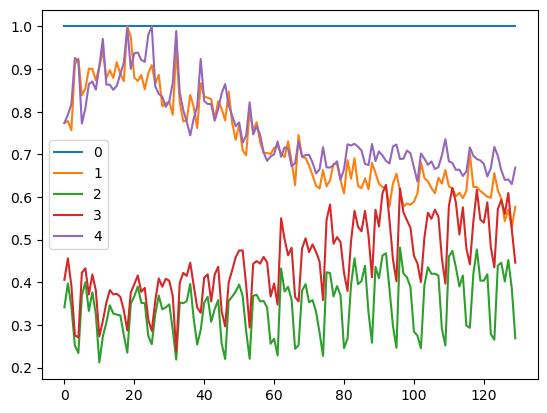

In [53]:
plt.plot(A[T0:,:], label=[0,1,2,3,4])
plt.legend()

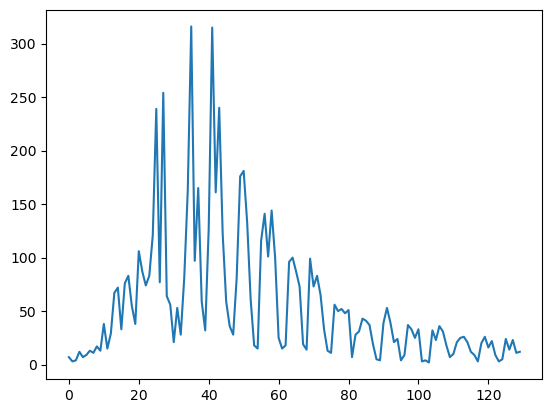

In [54]:
plt.plot(Y_data)

# 5. Sandwich estimator

In [55]:
L_HAC = np.floor(4* (T/100)**(2/9))

In [56]:
w_HAC = np.maximum(1 - np.abs(np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)

In [57]:
dltdr = np.array([dNBLLdr(y, m, rmle) for y, m in zip(Y_data, EY)])
dltdm = dldEY * Pi_inv_ImG[:,0]
dltdb = dldEY * d1EY

In [58]:
dltdth = np.concatenate([np.array([dltdr, dltdm]), dltdb], 0)

In [59]:
VEdl = dltdth @ w_HAC @ dltdth.T

In [60]:
VEdl

array([[8.74094905e+00, 2.74912723e+00, 1.06754594e+02, 8.52154763e+01,
        3.93616298e+01, 4.62862848e+01, 8.35192936e+01],
       [2.74912723e+00, 3.74442485e+00, 1.17580852e+02, 9.41664399e+01,
        4.33045525e+01, 5.06994658e+01, 9.20037475e+01],
       [1.06754594e+02, 1.17580852e+02, 4.96683497e+03, 3.92728926e+03,
        1.84235278e+03, 2.18116728e+03, 3.86155447e+03],
       [8.52154763e+01, 9.41664399e+01, 3.92728926e+03, 3.10888013e+03,
        1.45569751e+03, 1.72201591e+03, 3.05567023e+03],
       [3.93616298e+01, 4.33045525e+01, 1.84235278e+03, 1.45569751e+03,
        6.83715342e+02, 8.09856509e+02, 1.43167452e+03],
       [4.62862848e+01, 5.06994658e+01, 2.18116728e+03, 1.72201591e+03,
        8.09856509e+02, 9.59830712e+02, 1.69409238e+03],
       [8.35192936e+01, 9.20037475e+01, 3.86155447e+03, 3.05567023e+03,
        1.43167452e+03, 1.69409238e+03, 3.00383723e+03]])

In [61]:
Ihat_sdw = Ihat_dth @ la.inv(VEdl) @ Ihat_dth

In [62]:
Ihat_sdw

array([[ 2.56295670e-01, -3.27221000e-01, -2.47395981e+01,
        -1.95885566e+01, -9.18090512e+00, -1.08857517e+01,
        -1.92884018e+01],
       [-3.27221000e-01,  7.87860163e+00,  2.74508651e+02,
         2.15181444e+02,  1.02530720e+02,  1.21739464e+02,
         2.11825241e+02],
       [-2.47395981e+01,  2.74508651e+02,  1.37541833e+04,
         1.07176819e+04,  5.15763704e+03,  6.16512968e+03,
         1.05964976e+04],
       [-1.95885566e+01,  2.15181444e+02,  1.07176819e+04,
         8.35959142e+03,  4.01630168e+03,  4.79797915e+03,
         8.26261812e+03],
       [-9.18090512e+00,  1.02530720e+02,  5.15763704e+03,
         4.01630168e+03,  1.93496511e+03,  2.31389500e+03,
         3.97171807e+03],
       [-1.08857517e+01,  1.21739464e+02,  6.16512968e+03,
         4.79797915e+03,  2.31389500e+03,  2.76812136e+03,
         4.74569587e+03],
       [-1.92884018e+01,  2.11825241e+02,  1.05964976e+04,
         8.26261812e+03,  3.97171807e+03,  4.74569587e+03,
         8.1676933

In [63]:
Ihat_dth

array([[ 1.04856699e+00, -3.32835895e-03,  2.19789468e-02,
         6.70993040e-03,  3.30698996e-03,  1.07526101e-02,
         2.01214788e-02],
       [-3.32835895e-03,  4.14388242e+00,  1.41197729e+02,
         1.11856577e+02,  5.23627215e+01,  6.17754785e+01,
         1.09745779e+02],
       [ 2.19789468e-02,  1.41197729e+02,  6.72308993e+03,
         5.26711352e+03,  2.51036019e+03,  2.99115415e+03,
         5.19822952e+03],
       [ 6.70993040e-03,  1.11856577e+02,  5.26711352e+03,
         4.13150538e+03,  1.96509220e+03,  2.33957773e+03,
         4.07587769e+03],
       [ 3.30698996e-03,  5.23627215e+01,  2.51036019e+03,
         1.96509220e+03,  9.37888740e+02,  1.11810991e+03,
         1.93990367e+03],
       [ 1.07526101e-02,  6.17754785e+01,  2.99115415e+03,
         2.33957773e+03,  1.11810991e+03,  1.33368783e+03,
         2.31023149e+03],
       [ 2.01214788e-02,  1.09745779e+02,  5.19822952e+03,
         4.07587769e+03,  1.93990367e+03,  2.31023149e+03,
         4.0216011

In [64]:
la.inv(Ihat_sdw)[2:,2:]

array([[  97.54217932, -169.75715129,  135.28899289, -199.20856885,
          95.32418223],
       [-169.75715886,  337.3675809 , -301.29321023,  395.68950527,
        -204.71714764],
       [ 135.28900675, -301.29322609,  476.55180349, -464.34088204,
         168.24457889],
       [-199.20857857,  395.68950806, -464.34086674,  530.7428237 ,
        -225.17952696],
       [  95.32418875, -204.71715125,  168.24457185, -225.17952919,
         132.48605728]])

In [65]:
np.sqrt(np.diag(la.inv(Ihat_sdw))[2:])

array([ 9.87634443, 18.36756873, 21.8300665 , 23.03785632, 11.51025878])